In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update(
    {
        # Font settings for clarity and compatibility with academic publications
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size": 14,  # Base font size for better readability
        "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
        # Figure aesthetics & size for detailed visuals and fit on publication pages
        "figure.figsize": [8, 4],  # Default figure size
        "figure.facecolor": "white",  # White figure background for clean print
        "figure.autolayout": True,  # Automatic layout adjustments
        "figure.dpi": 400,  # High resolution figures for publication quality
        "savefig.dpi": 400,  # High resolution saving settings
        "savefig.format": "pdf",  # Save figures in PDF format for publications
        "savefig.bbox": "tight",  # Tight bounding box around figures
        # title, xlabel and ylabel bold
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        # Axes aesthetics for clarity and precision
        "axes.labelsize": 12,
        "axes.titlesize": 18,  # Prominent titles for immediate recognition
        "axes.facecolor": "white",  # White axes background
        "axes.grid": True,  # Enable grid for better readability
        "axes.spines.top": False,  # Disable top spine for aesthetic purposes
        "axes.spines.right": False,  # Disable right spine for aesthetic purposes
        "axes.formatter.limits": (0, 5),  # Threshold for scientific notation
        "axes.formatter.use_mathtext": True,  # Use mathtext for scientific notations
        "axes.formatter.useoffset": False,  # Disable offset on axes
        "axes.xmargin": 0,  # No margin around x-axis
        "axes.ymargin": 0,  # No margin around y-axis
        # Legend aesthetics
        "legend.fontsize": 12,
        "legend.frameon": False,  # No frame around legend for cleaner look
        "legend.loc": "best",  # Optimal legend positioning
        # Line aesthetics
        "lines.linewidth": 2,  # Thicker lines for visibility
        "lines.markersize": 8,  # Slightly smaller markers for balance
        # Tick aesthetics
        "xtick.labelsize": 12,
        "xtick.direction": "in",  # Ticks inside the plot
        "xtick.top": False,  # Disable top ticks for aesthetic purposes
        "ytick.labelsize": 12,
        "ytick.direction": "in",  # Ticks inside the plot
        "ytick.right": False,  # Disable right ticks for aesthetic purposes
        # Grid settings
        "grid.color": "grey",  # Grid color
        "grid.linestyle": "--",  # Dashed grid lines
        "grid.linewidth": 0.5,  # Thin grid lines
        # Error bar aesthetics
        "errorbar.capsize": 4,  # Error bar cap length
        # Layout settings
        "figure.subplot.wspace": 0.4,  # Adjust horizontal spacing between subplots
        "figure.subplot.hspace": 0.4,  # Adjust vertical spacing between subplots
        # Latex and color map settings
        "image.cmap": "viridis",  # Preferred color map for images
        "text.latex.preamble": r"\usepackage{amsmath}",  # Latex preamble for math expressions
    }
)

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
def check_pytorch():
    # Print PyTorch version
    print(f"PyTorch version: {torch.__version__}")

    # Check CUDA availability
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")

    if cuda_available:
        # Print CUDA version
        print(f"CUDA version: {torch.version.cuda}")
        
        # List available GPUs
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")
        
check_pytorch()

PyTorch version: 2.2.1+cu121
CUDA available: True
CUDA version: 12.1
Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU


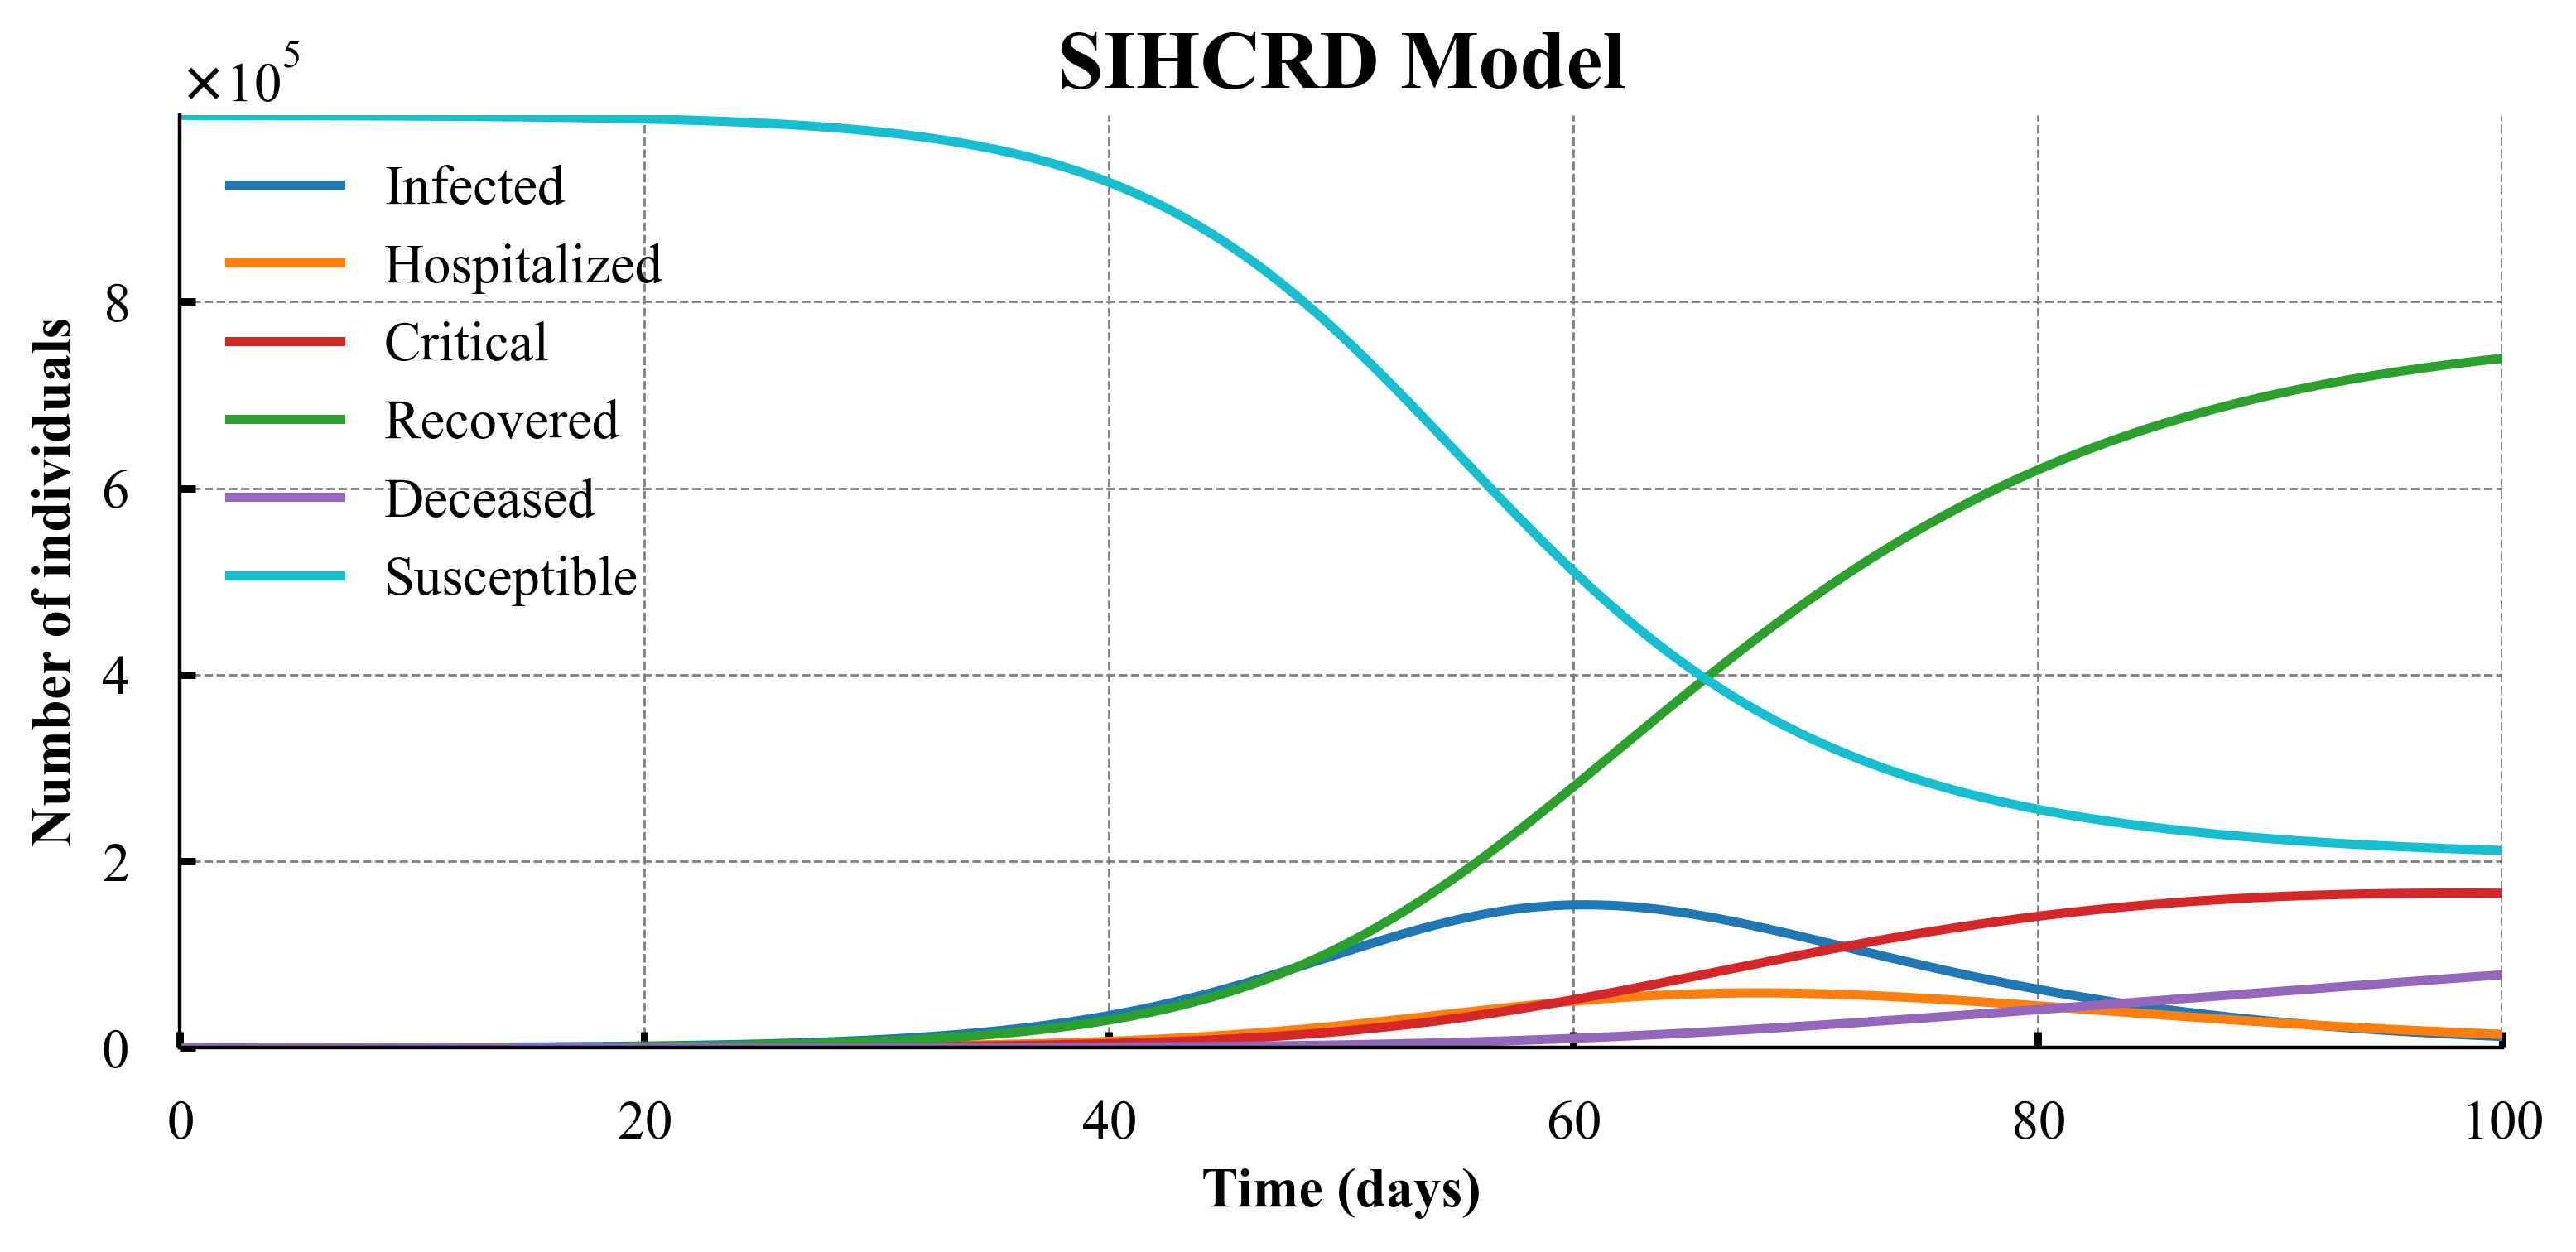

In [5]:
# N is the total population
def SIHCRD_model(t, y, beta, gamma, delta, alpha, N):
    """
    Define the SIHCRD model as a system of differential equations.

    Parameters:
    - t: Time variable.
    - y: State variables [S, I, H, C, R, D].
    - beta: Infection rate.
    - gamma: Recovery rate.
    - delta: Death rate.
    - alpha: Hospitalization rate.
    - N: Total population.

    Returns:
    - A list of the derivatives for each state variable.
    """
    S, I, H, C, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + alpha) * I
    dHdt = alpha * I - (gamma + delta) * H
    dCdt = gamma * H - delta * C
    dRdt = gamma * (H + I)
    dDdt = delta * (H + C)
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


# Define the initial conditions
def initial_conditions(N, I0, H0, C0, R0, D0):
    """
    Define the initial conditions for the SIHCRD model.

    Parameters:
    - N: Total population.
    - I0: Initial number of infected individuals.
    - H0: Initial number of hospitalized individuals.
    - C0: Initial number of critical individuals.
    - R0: Initial number of recovered individuals.
    - D0: Initial number of deceased individuals.

    Returns:
    - A list of the initial conditions for each state variable.
    """
    S0 = N - I0 - H0 - C0 - R0 - D0
    return [S0, I0, H0, C0, R0, D0]


# Define the time span
t0 = 0
tf = 100

# Define the parameters
N = 1e6
I0 = 100
H0 = 0
C0 = 0
R0 = 0
D0 = 0
beta = 0.3
gamma = 0.1
delta = 0.01
alpha = 0.05

# Define the initial conditions
y0 = initial_conditions(N, I0, H0, C0, R0, D0)

# Solve the system of differential equations
sol = solve_ivp(
    SIHCRD_model,
    [t0, tf],
    y0,
    args=(beta, gamma, delta, alpha, N),
    dense_output=True,
)

# Extract the solution
t = np.linspace(t0, tf, 1000)
y = sol.sol(t)

# Plot the solution
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, y[1], label="Infected", color="tab:blue")
ax.plot(t, y[2], label="Hospitalized", color="tab:orange")
ax.plot(t, y[3], label="Critical", color="tab:red")
ax.plot(t, y[4], label="Recovered", color="tab:green")
ax.plot(t, y[5], label="Deceased", color="tab:purple")
ax.plot(t, y[0], label="Susceptible", color="tab:cyan")  # Add susceptible population
ax.set_xlabel("Time (days)")
ax.set_ylabel("Number of individuals")
ax.set_title("SIHCRD Model")
ax.legend()
plt.show()

In [6]:
df = pd.read_csv("../data/processed/england_data.csv").drop(
    columns=["Unnamed: 0"], axis=1
)

df.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England


In [7]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # Apply rolling average
    for col in [
        "cumulative_confirmed",
        "cumulative_deceased",
        "hospitalCases",
        "covidOccupiedMVBeds",
        "recovered",
        "active_cases",
        "new_deceased",
    ]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """

    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.


    Args:

        df (pd.DataFrame): The input DataFrame with time series data.

        train_size (float): Proportion of the dataset to allocate to training.

        val_size (float): Proportion of the dataset to allocate to validation.

        test_size (float): Proportion of the dataset to allocate to testing.


    Returns:

        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """

    if not np.isclose(train_size + val_size + test_size, 1.0):

        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)

    train_end = int(n * train_size)

    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]

    val_data = df.iloc[train_end:val_end]

    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

In [8]:
data = load_and_preprocess_data(
    "../data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-02",
).drop(columns=["Unnamed: 0"], axis=1)


# # split data

# train_data, val_data, test_data = split_time_series_data(data, train_size=0.7, val_size=0.15, test_size=0.15)


# train_data = train_data.head(100)

data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-02,939.000000,35138,15454.000000,3937,3895.0,709.500000,37518.500000,5092.500000,56171302,England,0,0.0,32426.000000,56131836.0
1,2020-04-03,1379.666667,38526,16355.333333,3388,3878.0,718.666667,39460.333333,5459.000000,56171302,England,1,0.0,34001.333333,56127958.0
2,2020-04-04,1649.250000,41972,17388.750000,3446,3260.0,746.000000,41246.250000,5849.250000,56171302,England,2,0.0,35397.000000,56124698.0
3,2020-04-05,1849.400000,45418,18321.200000,3446,2994.0,761.400000,42916.600000,6248.000000,56171302,England,3,0.0,36668.600000,56121704.0
4,2020-04-06,2022.500000,48940,19023.166667,3522,4170.0,767.000000,44725.166667,6646.333333,56171302,England,4,0.0,38078.833333,56117534.0


In [9]:
train_data_start = "2020-05-01"
train_data_end = "2020-08-31"

val_data_start = "2020-09-01"
val_data_end = "2020-10-31"

t_mask = (data["date"] >= train_data_start) & (data["date"] <= train_data_end)
train_data = data.loc[t_mask]

v_mask = (data["date"] >= val_data_start) & (data["date"] <= val_data_end)
val_data = data.loc[v_mask]

In [10]:
def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = (
        torch.tensor(range(1, len(data) + 1), dtype=torch.float32)
        .view(-1, 1)
        .to(device)
        .requires_grad_(True)
    )
    # S = torch.tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = (
        torch.tensor(data["active_cases"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    R = (
        torch.tensor(data["recovered"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    D = (
        torch.tensor(data["new_deceased"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    H = (
        torch.tensor(data["hospitalCases"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    C = (
        torch.tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, I, R, D, H, C


features = [
    # "S(t)",
    "active_cases",
    "hospitalCases",
    "covidOccupiedMVBeds",
    "recovered",
    "new_deceased",
]

In [11]:
scaler = MinMaxScaler()
scaler.fit(train_data[features])

scaled_train_data = pd.DataFrame(
    scaler.transform(train_data[features]), columns=features
)
scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)


t_train, I_train, R_train, D_train, H_train, C_train = prepare_tensors(
    scaled_train_data, device
)

t_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(scaled_val_data, device)

train_tensor_data = torch.cat([I_train, H_train, C_train, R_train, D_train], dim=1)
val_tensor_data = torch.cat([I_val, H_val, C_val, R_val, D_val], dim=1)

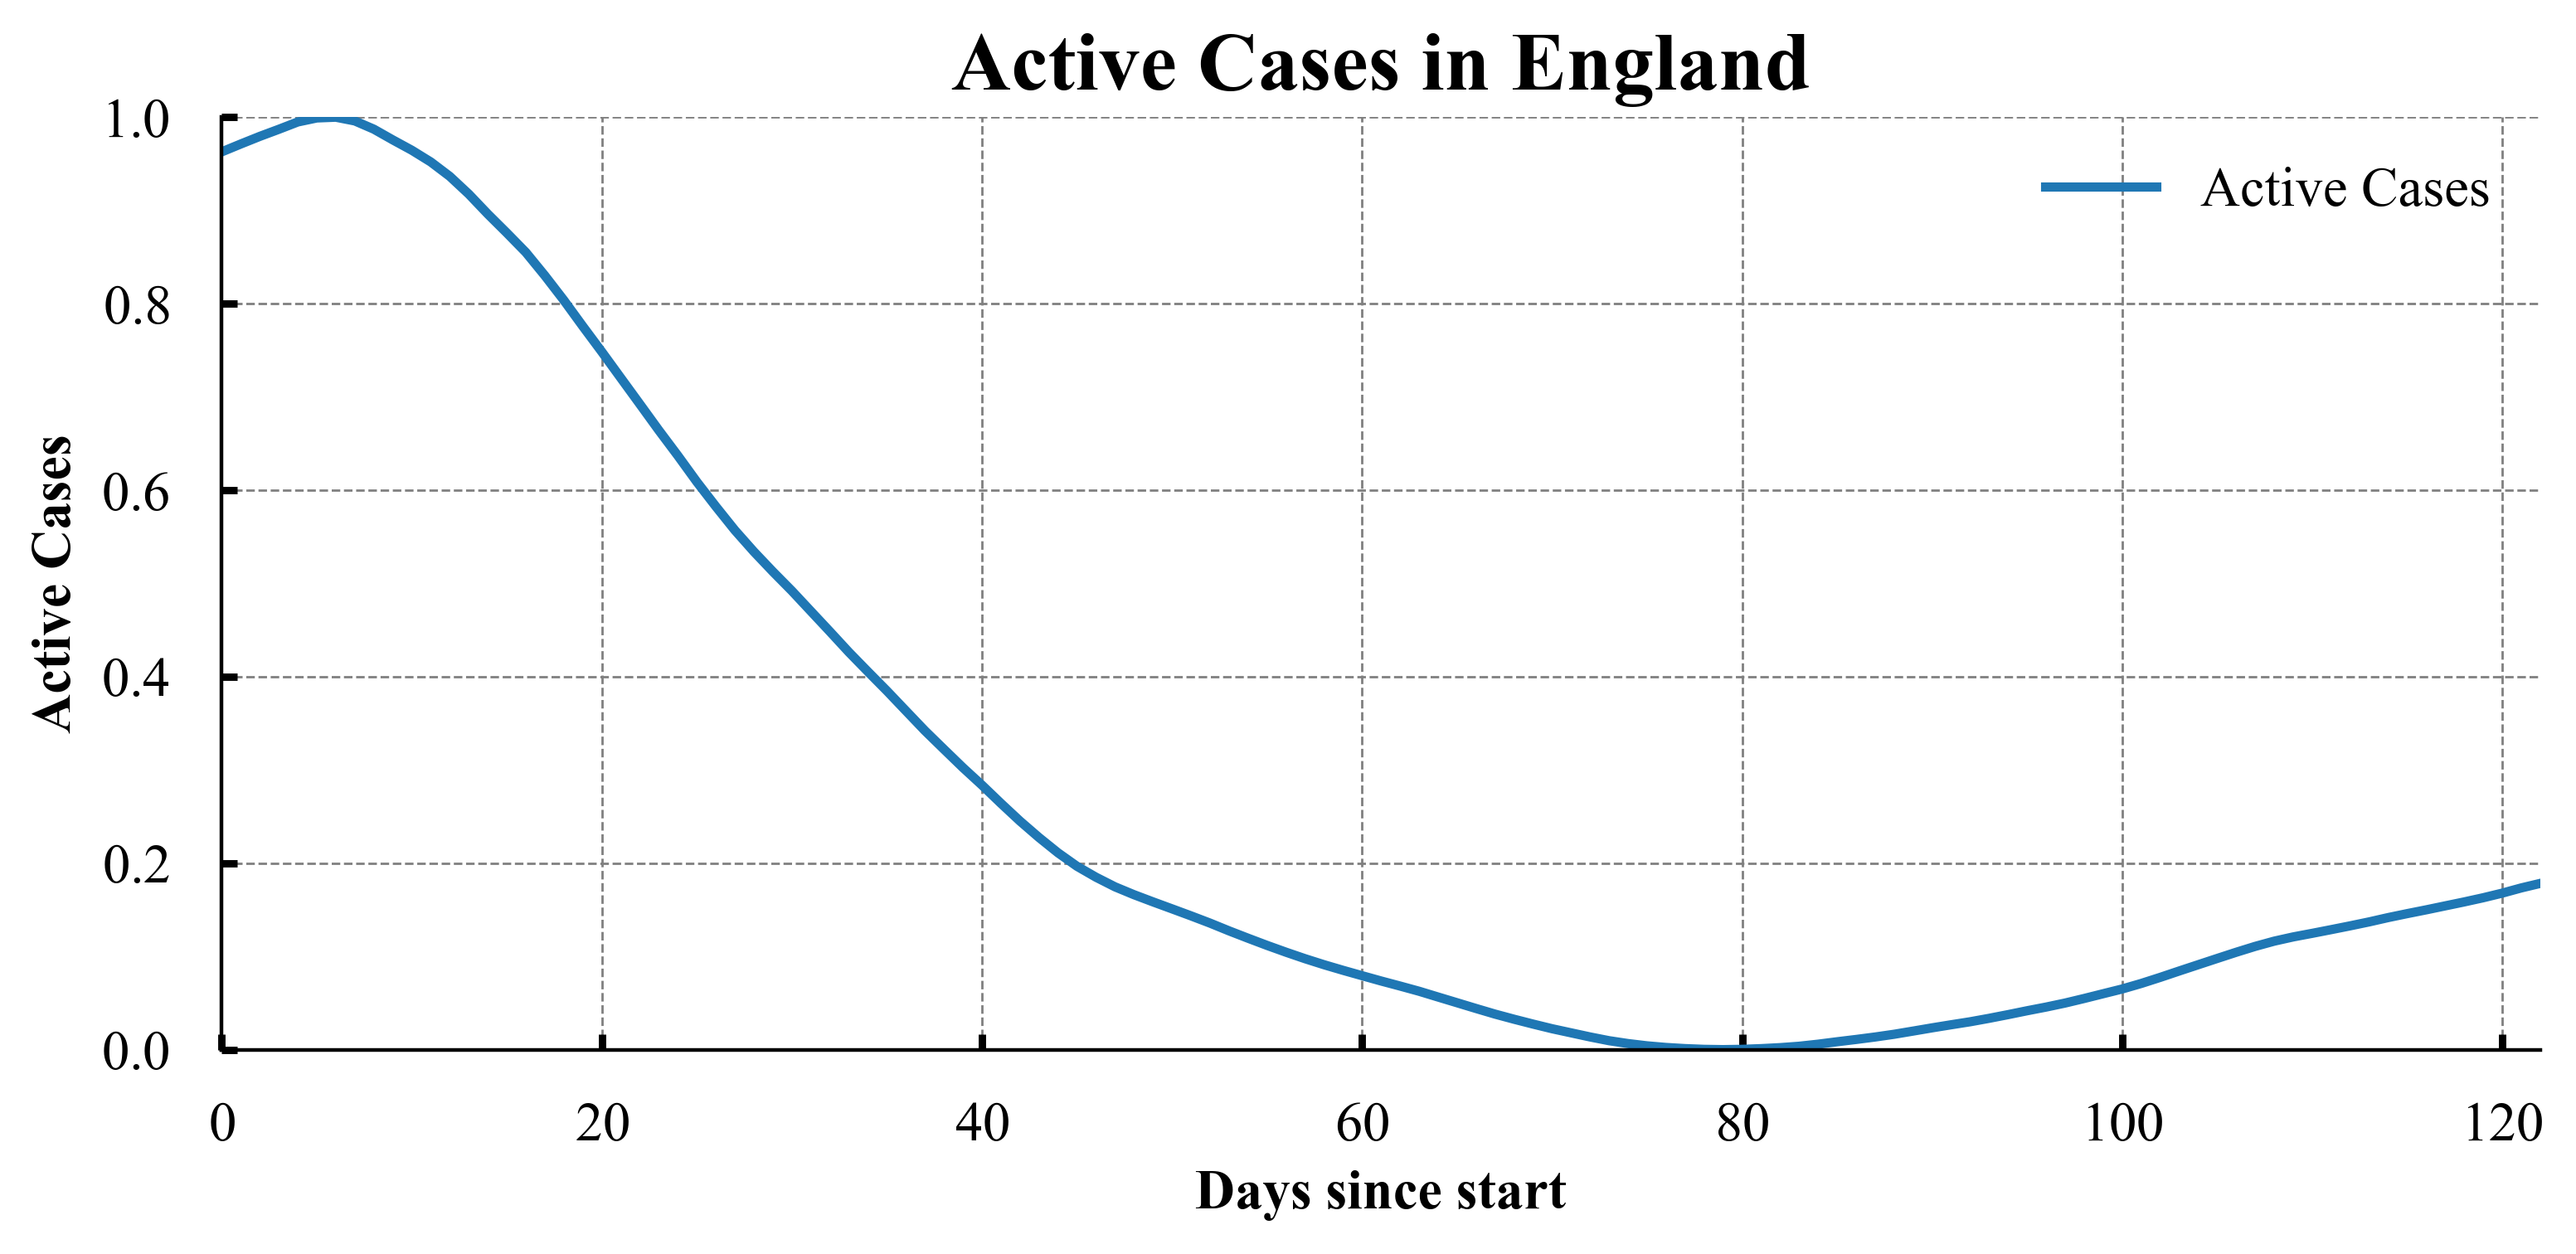

In [12]:
# plot I_train for the period available
plt.plot(I_train.cpu().detach().numpy(), label="Active Cases")
plt.title("Active Cases in England")
plt.xlabel("Days since start")
plt.ylabel("Active Cases")
plt.legend()
plt.show()

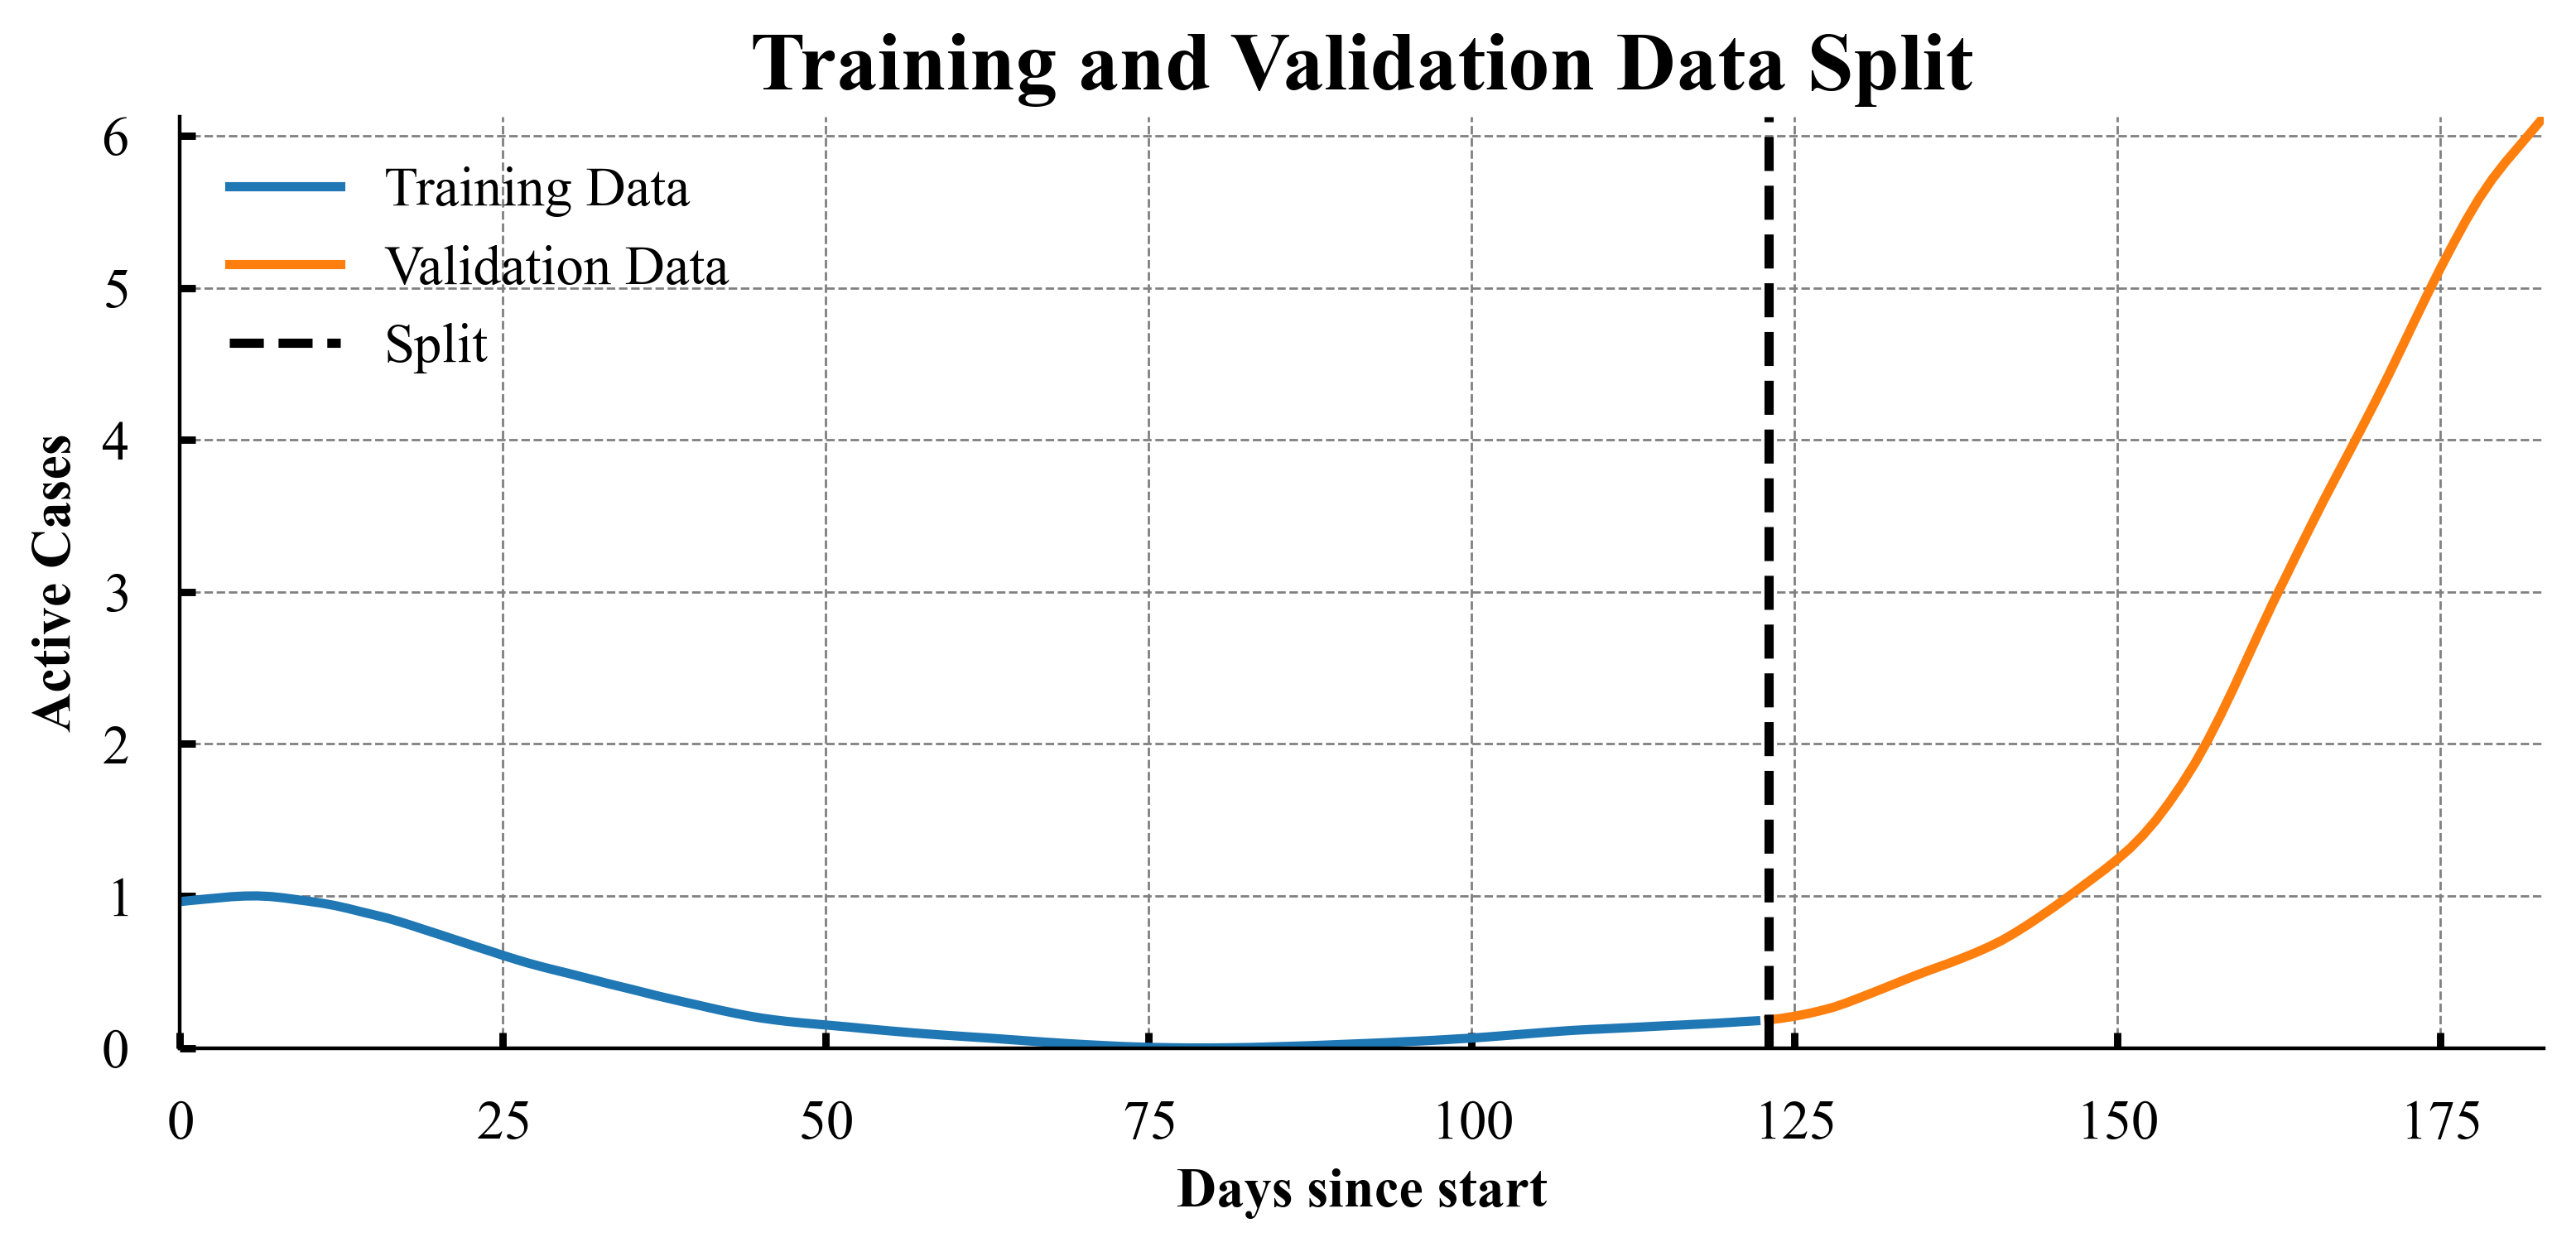

In [13]:
# plot the training data and validation data and show the split as a labeled straight dotted line
plt.plot(I_train.cpu().detach().numpy(), label="Training Data")
plt.plot(
    range(len(I_train), len(I_train) + len(I_val)),
    I_val.cpu().detach().numpy(),
    label="Validation Data",
)
plt.axvline(x=len(I_train), color="black", linestyle="--", label="Split")
plt.title("Training and Validation Data Split")
plt.xlabel("Days since start")
plt.ylabel("Active Cases")
plt.legend()
plt.show()

In [14]:
# define the neural network for epi-net
class EpiNet(nn.Module):
    def __init__(self, num_layers=2, hidden_neurons=10, output_size=5):
        super(EpiNet, self).__init__()
        self.retain_seed = 100
        torch.manual_seed(self.retain_seed)

        # Initialize layers array starting with input layer
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]

        # Append hidden layers
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])

        # Append output layer
        layers.append(nn.Linear(hidden_neurons, output_size))  # Epidemiological outputs

        # Convert list of layers to nn.Sequential
        self.net = nn.Sequential(*layers)

        # Initialize weights
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    def init_xavier(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_normal_(layer.weight, gain=g)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

        self.net.apply(init_weights)

In [15]:
# define the neural network for beta parameter estimation
class BetaNet(nn.Module):
    def __init__(self, num_layers=2, hidden_neurons=10):
        super(BetaNet, self).__init__()
        self.retain_seed = 100
        torch.manual_seed(self.retain_seed)

        # Initialize layers array starting with the input layer
        layers = [nn.Linear(1, hidden_neurons), nn.LeakyReLU()]

        # Append hidden layers
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.LeakyReLU()])

        # Append output layer
        layers.append(
            nn.Linear(hidden_neurons, 1)
        )  # Output layer for estimating infection rate β

        # Convert list of layers to nn.Sequential
        self.net = nn.Sequential(*layers)

        # Initialize weights
        self.init_xavier()

    def forward(self, t):
        # Forward pass to compute β
        return self.get_params(t)

    def init_xavier(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                g = nn.init.calculate_gain("leaky_relu")
                nn.init.xavier_normal_(layer.weight, gain=g)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

        self.net.apply(init_weights)

    def get_params(self, t):
        # Ensure beta (β) is a positive value between 0 and 1 using the sigmoid function
        beta = torch.sigmoid(self.net(t)) * 0.9 + 0.1
        return beta

In [16]:
# define the neural network for time varying parameters estimation using relu activation
class TimeVaryingNet(nn.Module):
    def __init__(self, num_layers=2, hidden_neurons=10, output_size=5):
        super(TimeVaryingNet, self).__init__()

        # Initialize layers array starting with the input layer
        layers = [nn.Linear(1, hidden_neurons), nn.ReLU()]

        # Append hidden layers
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.ReLU()])

        # Append output layer
        layers.append(nn.Linear(hidden_neurons, output_size))

        # Convert list of layers to nn.Sequential
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)
    
    
    def get_params(self, t):
        raw_params = self.forward(t)
        # Ensure all parameters are positive values and using the sigmoid function to bound them between 0 and 1
        beta = torch.sigmoid(raw_params[:, 0]) * 0.9 + 0.1
        return beta

In [17]:

def pinn_loss(tensor_data, beta_net, model_output, t, N, device):
    I, H, C, R, D = tensor_data.unbind(1)

    # Calculate the predicted derivatives
    S = N - I.sum() - H.sum() - C.sum() - R.sum() - D.sum()
    S_pred = -beta_net(t) * S * I / N

    # Using grad outputs need to be of size [batch_size], not [batch_size, 1]
    S = S.view(-1)
    I_pred, H_pred, C_pred, R_pred, D_pred = model_output.unbind(1)
    I_pred, H_pred, C_pred, R_pred, D_pred = (
        I_pred.view(-1),
        H_pred.view(-1),
        C_pred.view(-1),
        R_pred.view(-1),
        D_pred.view(-1),
    )

    # Compute gradients
    s_t = torch.autograd.grad(outputs=S_pred, inputs=t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    i_t = torch.autograd.grad(outputs=I_pred, inputs=t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    h_t = torch.autograd.grad(outputs=H_pred, inputs=t, grad_outputs=torch.ones_like(H_pred), create_graph=True)[0]
    c_t = torch.autograd.grad(outputs=C_pred, inputs=t, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
    r_t = torch.autograd.grad(outputs=R_pred, inputs=t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    d_t = torch.autograd.grad(outputs=D_pred, inputs=t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    
    # parameters
    gamma = 0.1
    delta = 0.01
    alpha = 0.05

    # Compute residuals
    dSdt = s_t + beta_net(t).view(-1) * S * I / N
    dIdt = i_t - beta_net(t).view(-1) * S * I / N - (gamma + alpha) * I
    dHdt = h_t - alpha * I - (gamma + delta) * H
    dCdt = c_t - gamma * H - delta * C
    dRdt = r_t - gamma * (H + I)
    dDdt = d_t - delta * (H + C)

    # Loss components
    data_loss = torch.mean(
        (I - I_pred) ** 2
        + (H - H_pred) ** 2
        + (C - C_pred) ** 2
        + (R - R_pred) ** 2
        + (D - D_pred) ** 2
    )
    physics_loss = torch.mean(dSdt**2 + dIdt**2 + dHdt**2 + dCdt**2 + dRdt**2 + dDdt**2)
    initial_condition_loss = torch.mean(
        (I[0] - I_pred[0]) ** 2
        + (H[0] - H_pred[0]) ** 2
        + (C[0] - C_pred[0]) ** 2
        + (R[0] - R_pred[0]) ** 2
        + (D[0] - D_pred[0]) ** 2
    )

    # Total loss
    loss = data_loss + physics_loss + initial_condition_loss
    return loss

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [19]:
def train_model(
    model,
    beta_net,
    tensor_data,
    t_train,
    optimizer,
    N,
    num_epochs=1000,
    device=device,
    print_every=100,
):
    model.to(device)
    beta_net.to(device)
    tensor_data = tensor_data.to(device)
    early_stopping = EarlyStopping(patience=200, verbose=False)

    loss_history = []
    
    t = t_train

    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()

        # Forward pass
        model_output = model(t)
        loss = pinn_loss(tensor_data, beta_net, model_output, t, N, device)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Store loss value
        loss_history.append(loss.item())

        # Print statements
        if epoch % print_every == 0:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}")
            
        # check for early stopping
        early_stopping(loss.item())
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model, loss_history

In [20]:
# Define the model and beta net
model = EpiNet(num_layers=5, hidden_neurons=32, output_size=5).to(device)
# beta_net = BetaNet(num_layers=2, hidden_neurons=32).to(device)
beta_net = TimeVaryingNet(num_layers=2, hidden_neurons=32, output_size=1).to(device)

In [21]:
# Define the optimizer
lr = 1e-3
optimizer = optim.Adam(list(model.parameters()) + list(beta_net.parameters()), lr=lr)

# Define the parameters
N = 5e6

# Train the model
model, loss_history = train_model(
    model, beta_net, train_tensor_data, t_train, optimizer, N, num_epochs=10000, print_every=100
)

# Define the initial conditions
I0 = I_train[0].item()
H0 = H_train[0].item()
C0 = C_train[0].item()
R0 = R_train[0].item()
D0 = D_train[0].item()

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0 - Loss: 14.2363
Epoch 100 - Loss: 0.0413
Epoch 200 - Loss: 0.0296
Epoch 300 - Loss: 0.0262
Epoch 400 - Loss: 0.0211
Epoch 500 - Loss: 0.0194
Epoch 600 - Loss: 0.0186
Epoch 700 - Loss: 0.0179
Epoch 800 - Loss: 0.0175
Epoch 900 - Loss: 0.0172
Epoch 1000 - Loss: 0.0171
Epoch 1100 - Loss: 0.0170
Epoch 1200 - Loss: 0.0170
Epoch 1300 - Loss: 0.0173
Epoch 1400 - Loss: 0.0168
Epoch 1500 - Loss: 0.0167
Epoch 1600 - Loss: 0.0167
Epoch 1700 - Loss: 0.0167
Epoch 1800 - Loss: 0.0169
Epoch 1900 - Loss: 0.0166
Epoch 2000 - Loss: 0.0166
Epoch 2100 - Loss: 0.0175
Epoch 2200 - Loss: 0.0223
Epoch 2300 - Loss: 0.0166
Epoch 2400 - Loss: 0.0165
Epoch 2500 - Loss: 0.0167
Epoch 2600 - Loss: 0.0165
Epoch 2700 - Loss: 0.0165
Epoch 2800 - Loss: 0.0165
Epoch 2900 - Loss: 0.0165
Epoch 3000 - Loss: 0.0241
Epoch 3100 - Loss: 0.0165
Epoch 3200 - Loss: 0.0164
Epoch 3300 - Loss: 0.0164
Epoch 3400 - Loss: 0.0191
Epoch 3500 - Loss: 0.0164
Epoch 3600 - Loss: 0.0165
Epoch 3700 - Loss: 0.0164
Epoch 3800 - Loss: 0.01

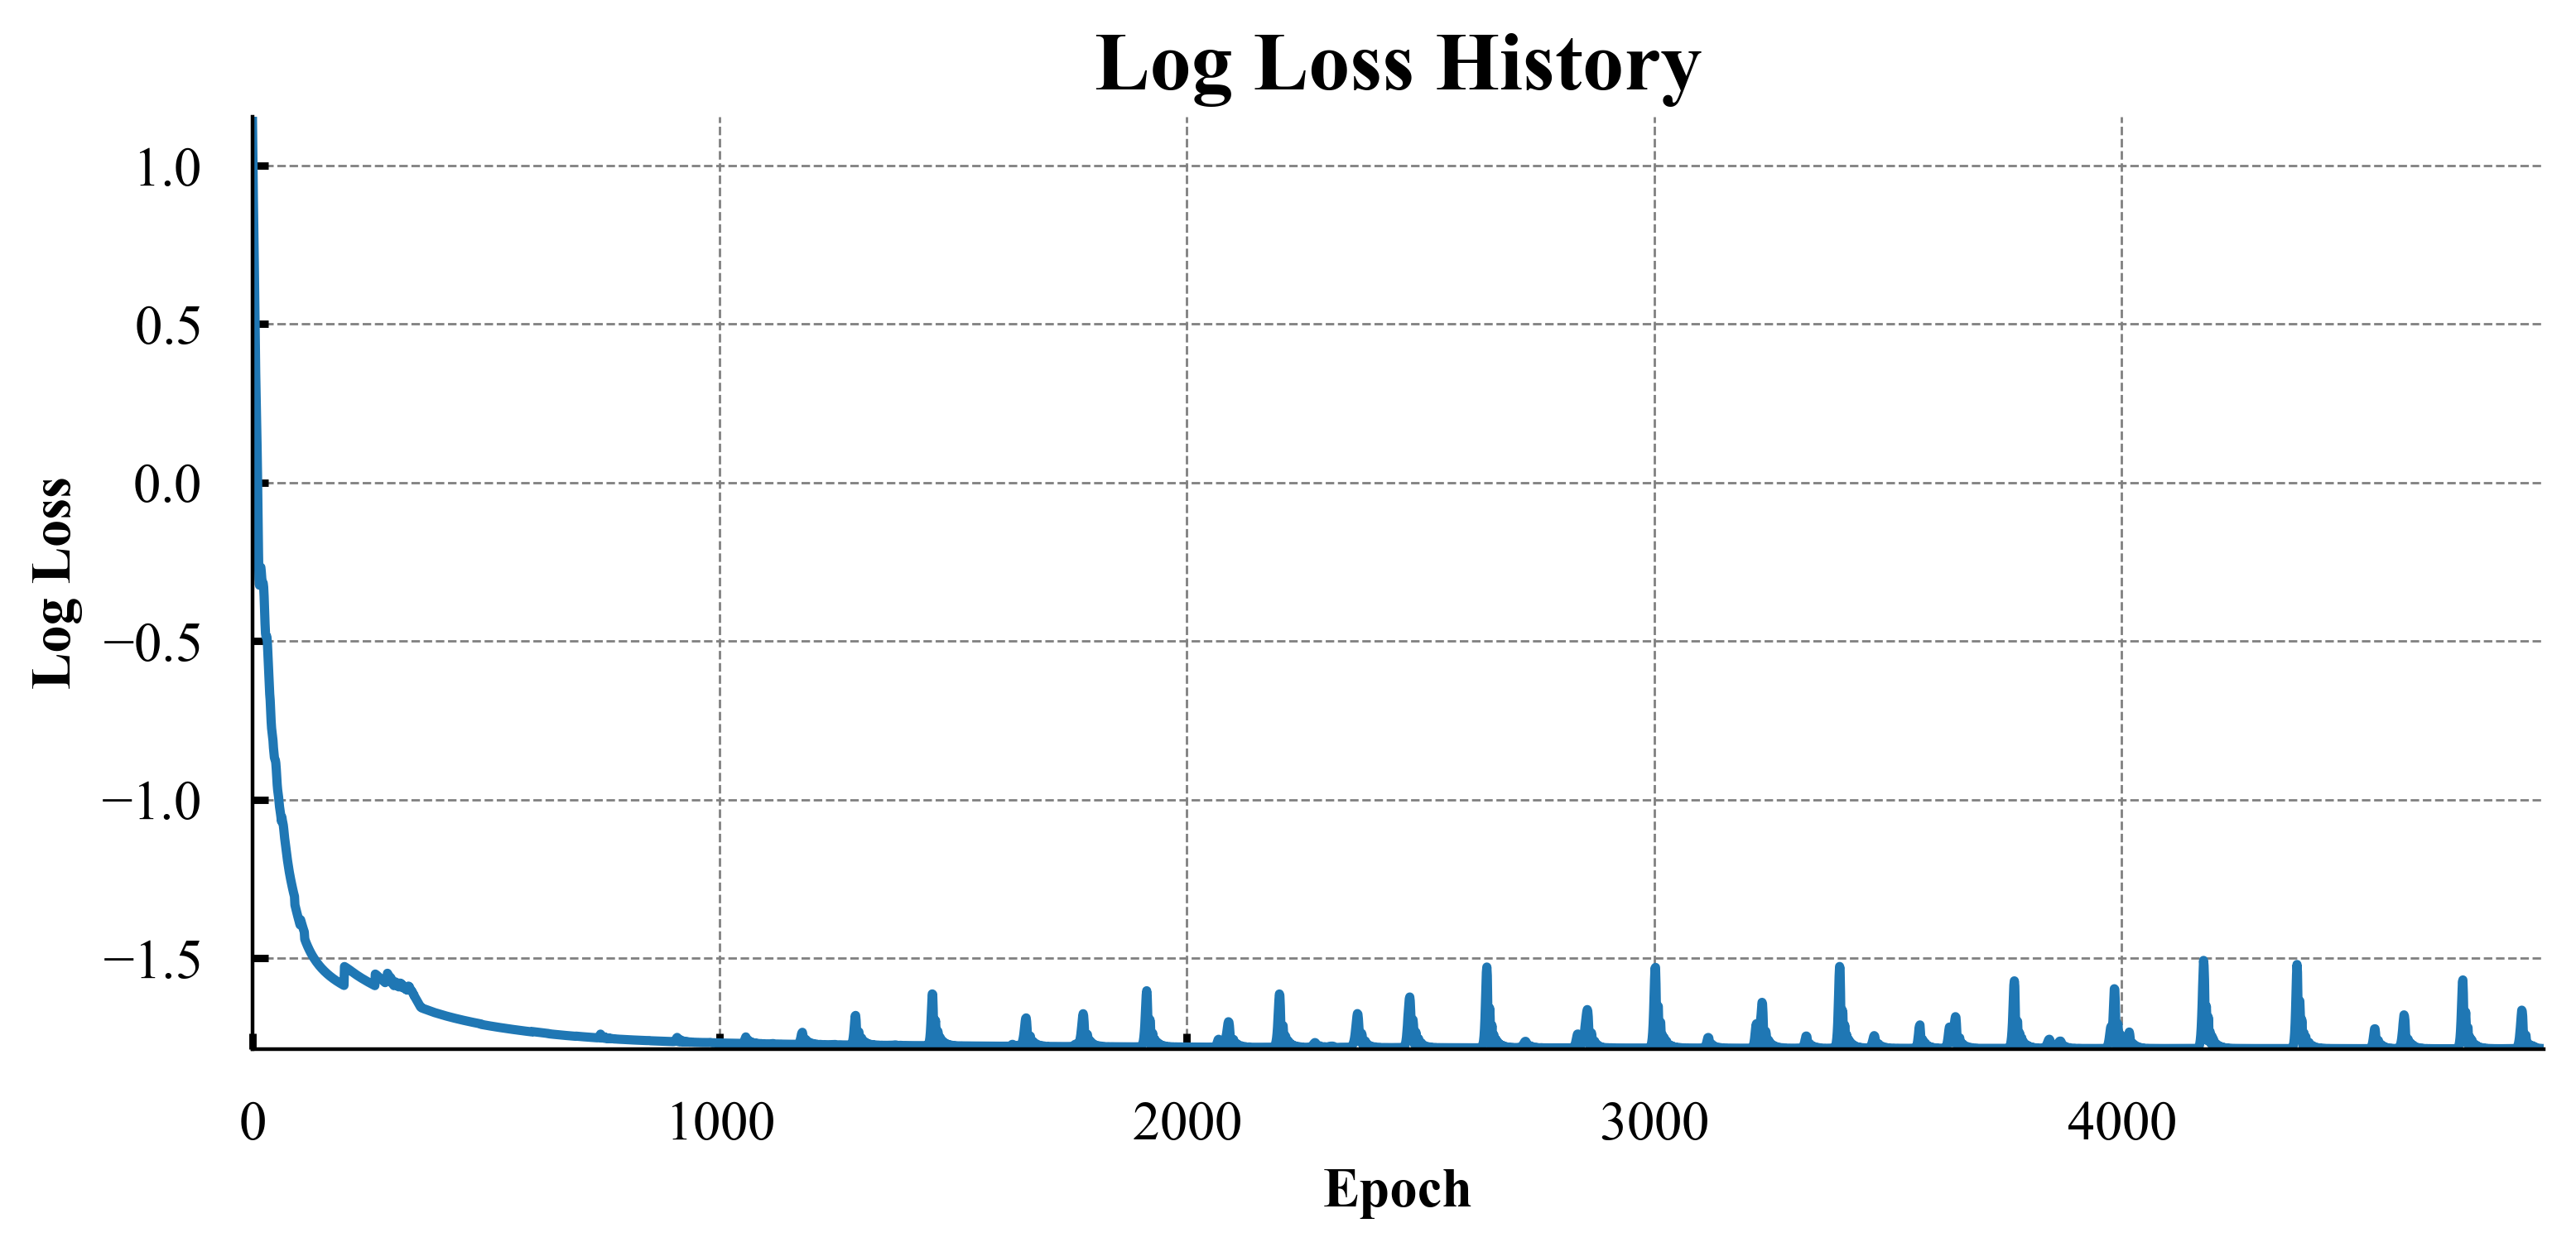

In [22]:
# plot the loss history in base 10
plt.plot(np.log10(loss_history))
plt.title("Log Loss History")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()


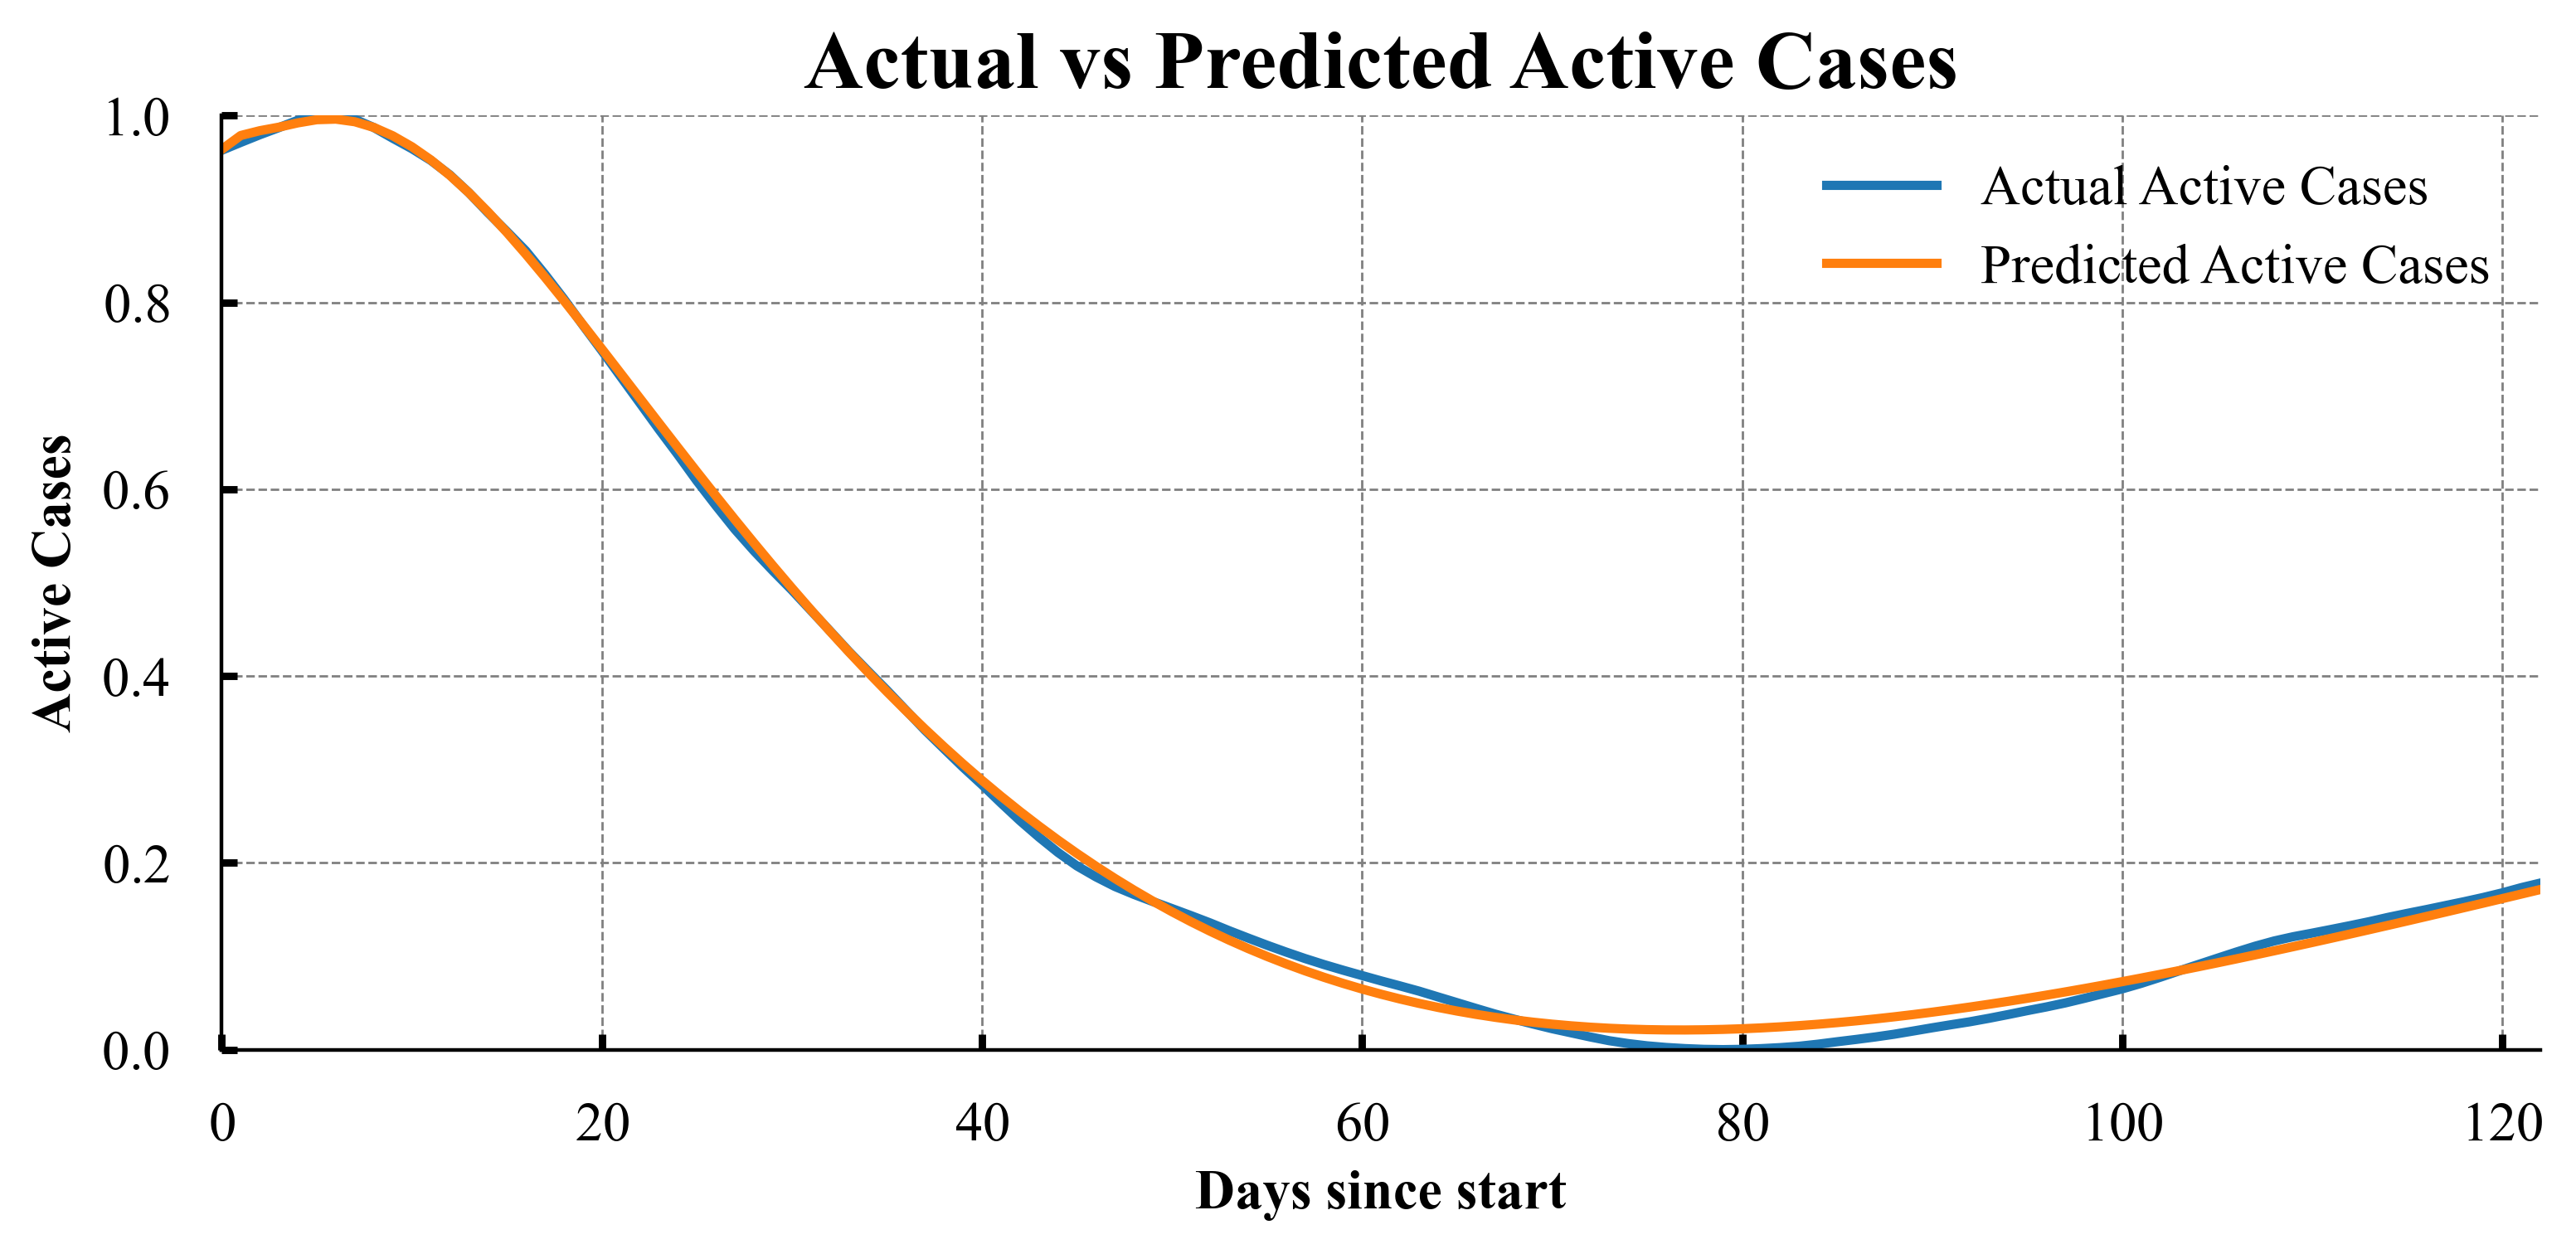

In [23]:
# plot the actual and predicted of the training data
model.eval()
with torch.no_grad():
    t = t_train
    I_pred, H_pred, C_pred, R_pred, D_pred = model(t).unbind(1)
    
    # plot the actual and predicted of the training data
    plt.plot(I_train.cpu().detach().numpy(), label="Actual Active Cases")
    plt.plot(I_pred.cpu().detach().numpy(), label="Predicted Active Cases")
    plt.title("Actual vs Predicted Active Cases")
    plt.xlabel("Days since start")
    plt.ylabel("Active Cases")
    plt.legend()
    plt.show()    

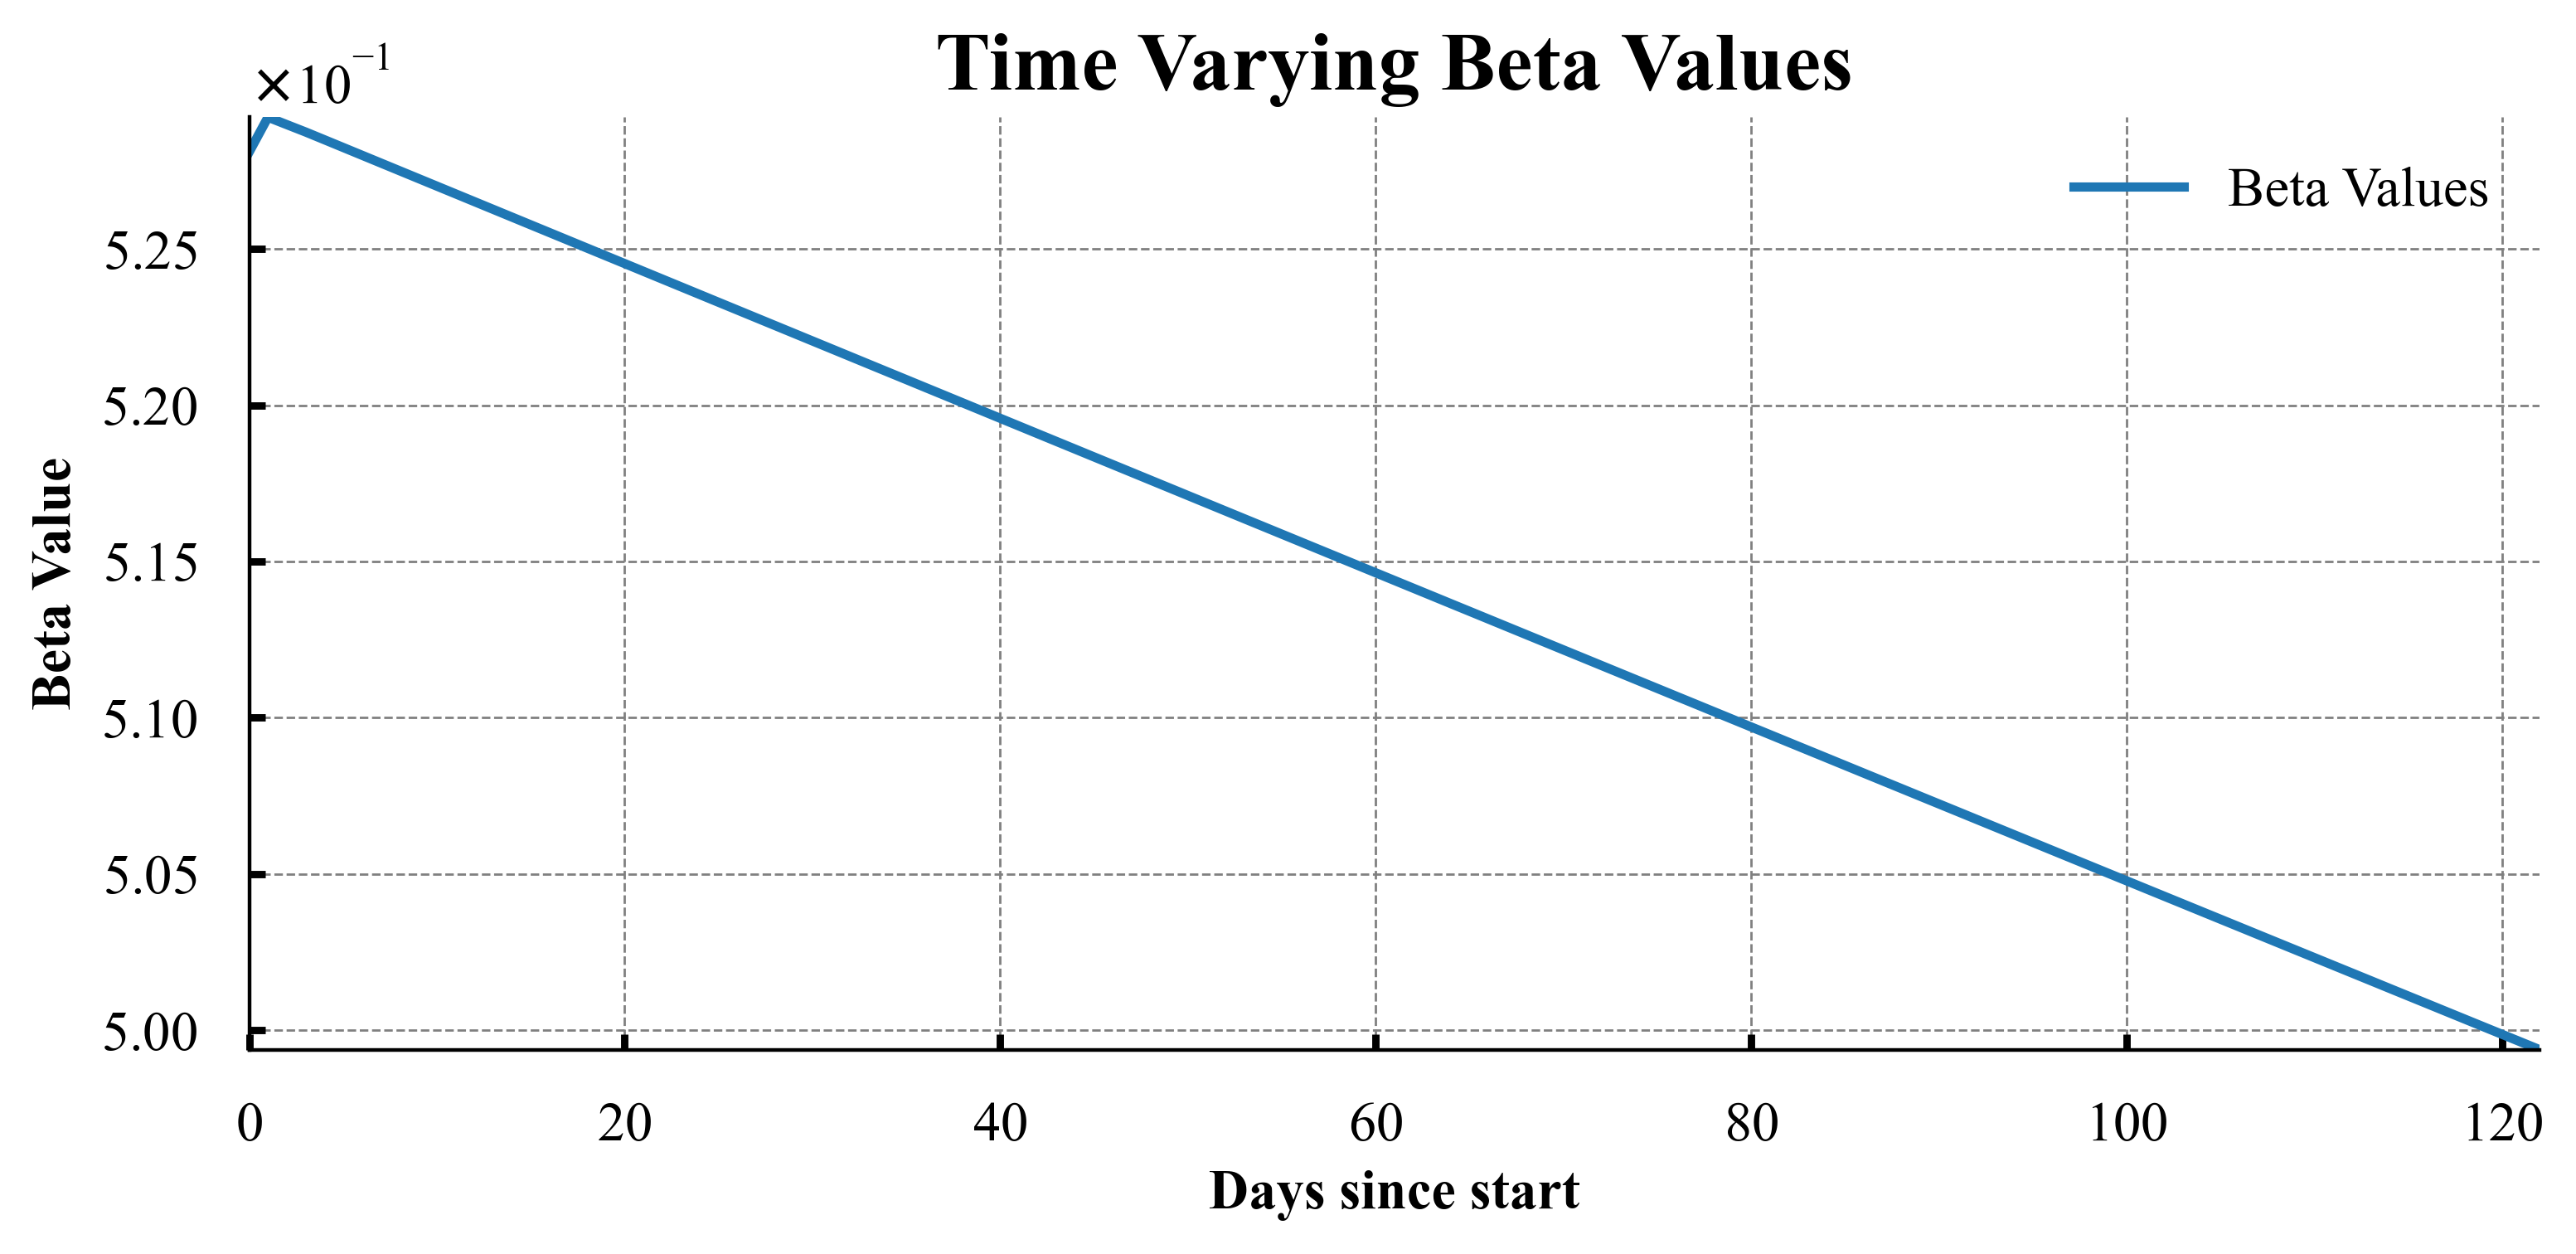

In [31]:
# extract the time varying beta values and plot them
beta_net.eval()
with torch.no_grad():
    beta_values = beta_net.get_params(t_train).cpu().detach().numpy()
    plt.plot(beta_values, label="Beta Values")
    plt.title("Time Varying Beta Values")
    plt.xlabel("Days since start")
    plt.ylabel("Beta Value")
    plt.legend()
    plt.show()

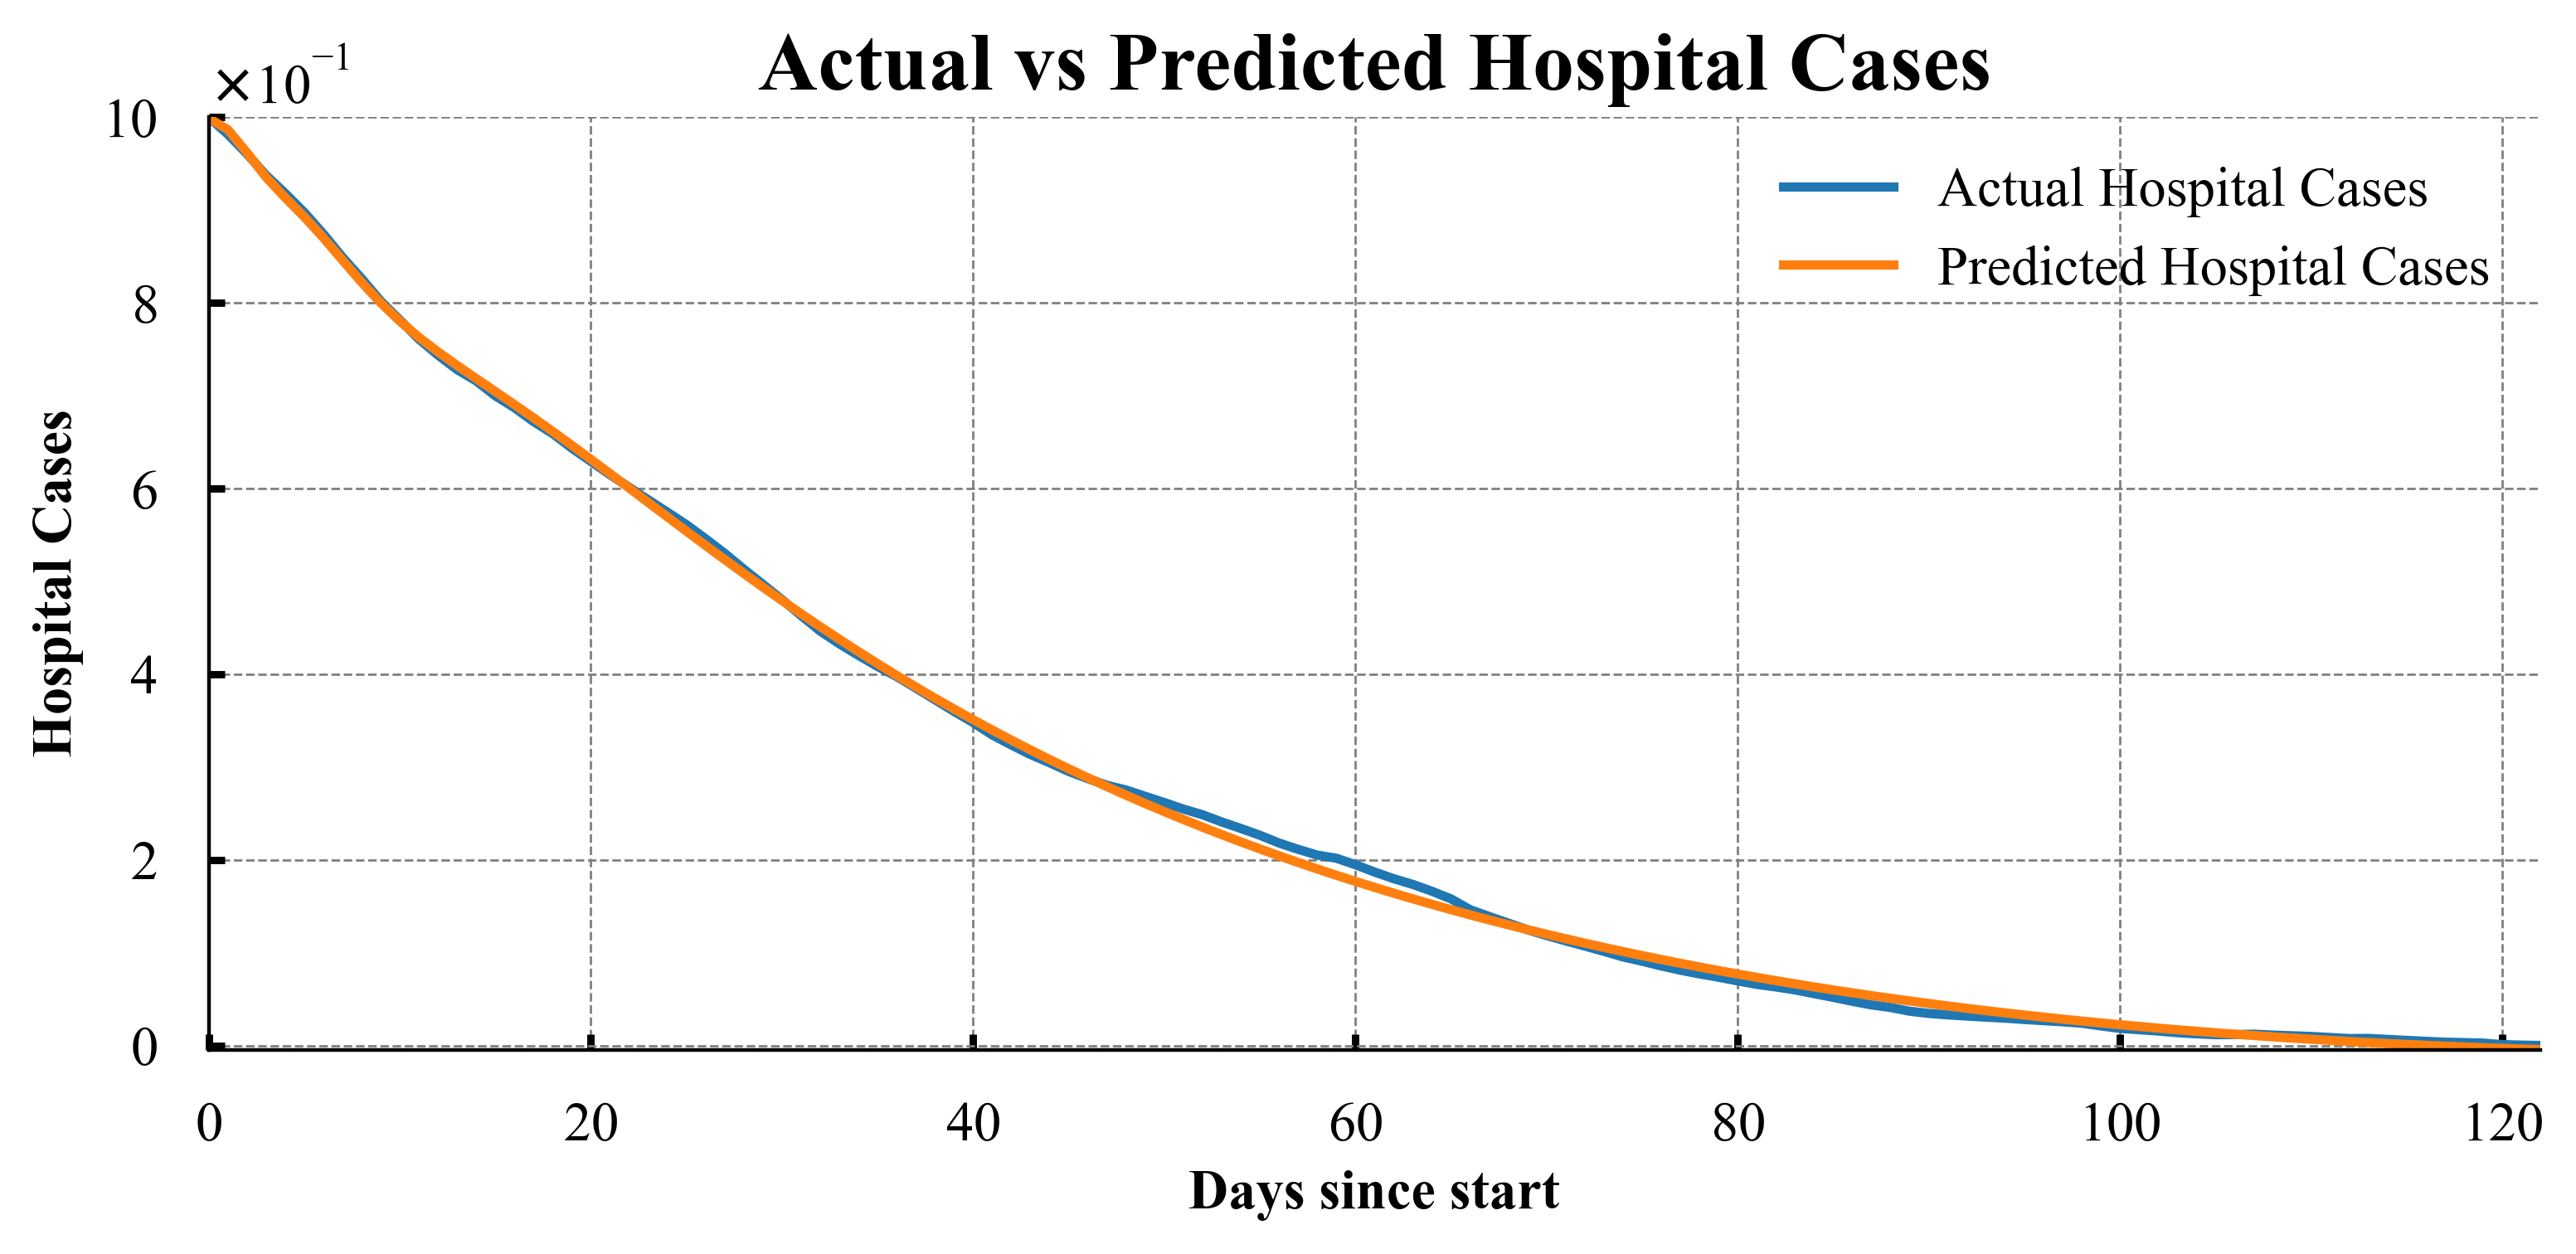

In [25]:
# plot the actual and predicted of the training data for hospital cases
plt.plot(H_train.cpu().detach().numpy(), label="Actual Hospital Cases")
plt.plot(H_pred.cpu().detach().numpy(), label="Predicted Hospital Cases")
plt.title("Actual vs Predicted Hospital Cases")
plt.xlabel("Days since start")
plt.ylabel("Hospital Cases")
plt.legend()
plt.show()


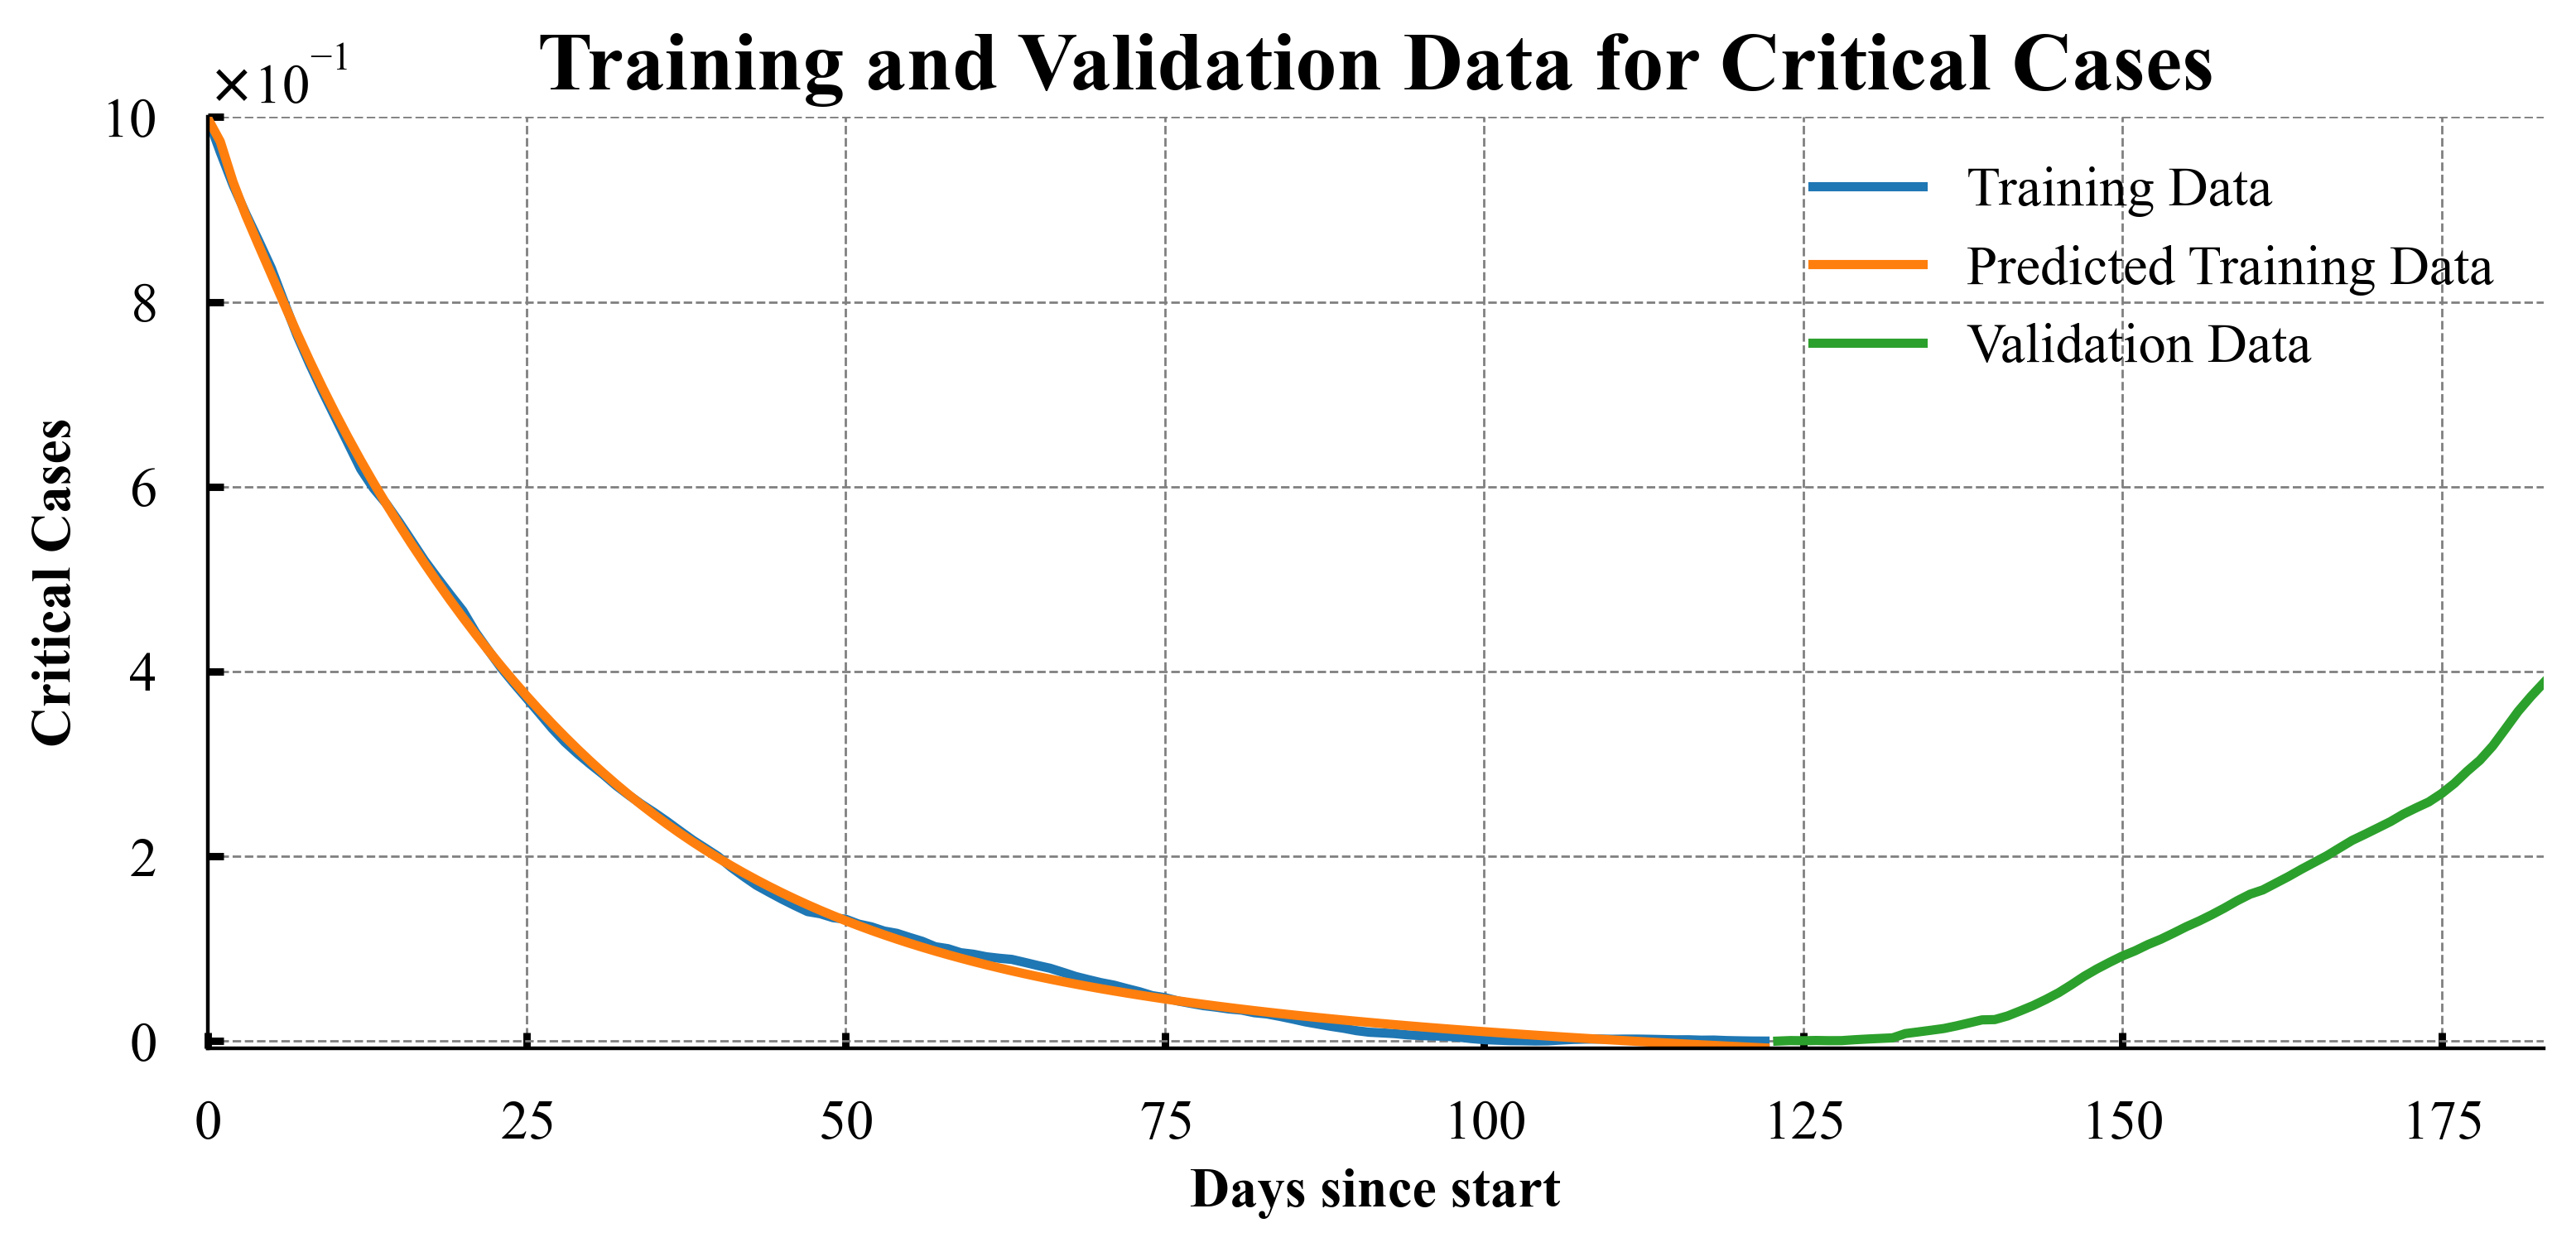

In [26]:
# plot the actual and predicted of the training data for critical cases and the validation data actual and predicted for critical cases
plt.plot(C_train.cpu().detach().numpy(), label="Training Data")
plt.plot(C_pred.cpu().detach().numpy(), label="Predicted Training Data")
plt.plot(range(len(C_train), len(C_train) + len(C_val)), C_val.cpu().detach().numpy(), label="Validation Data")
plt.title("Training and Validation Data for Critical Cases")
plt.xlabel("Days since start")
plt.ylabel("Critical Cases")
plt.legend()
plt.show()

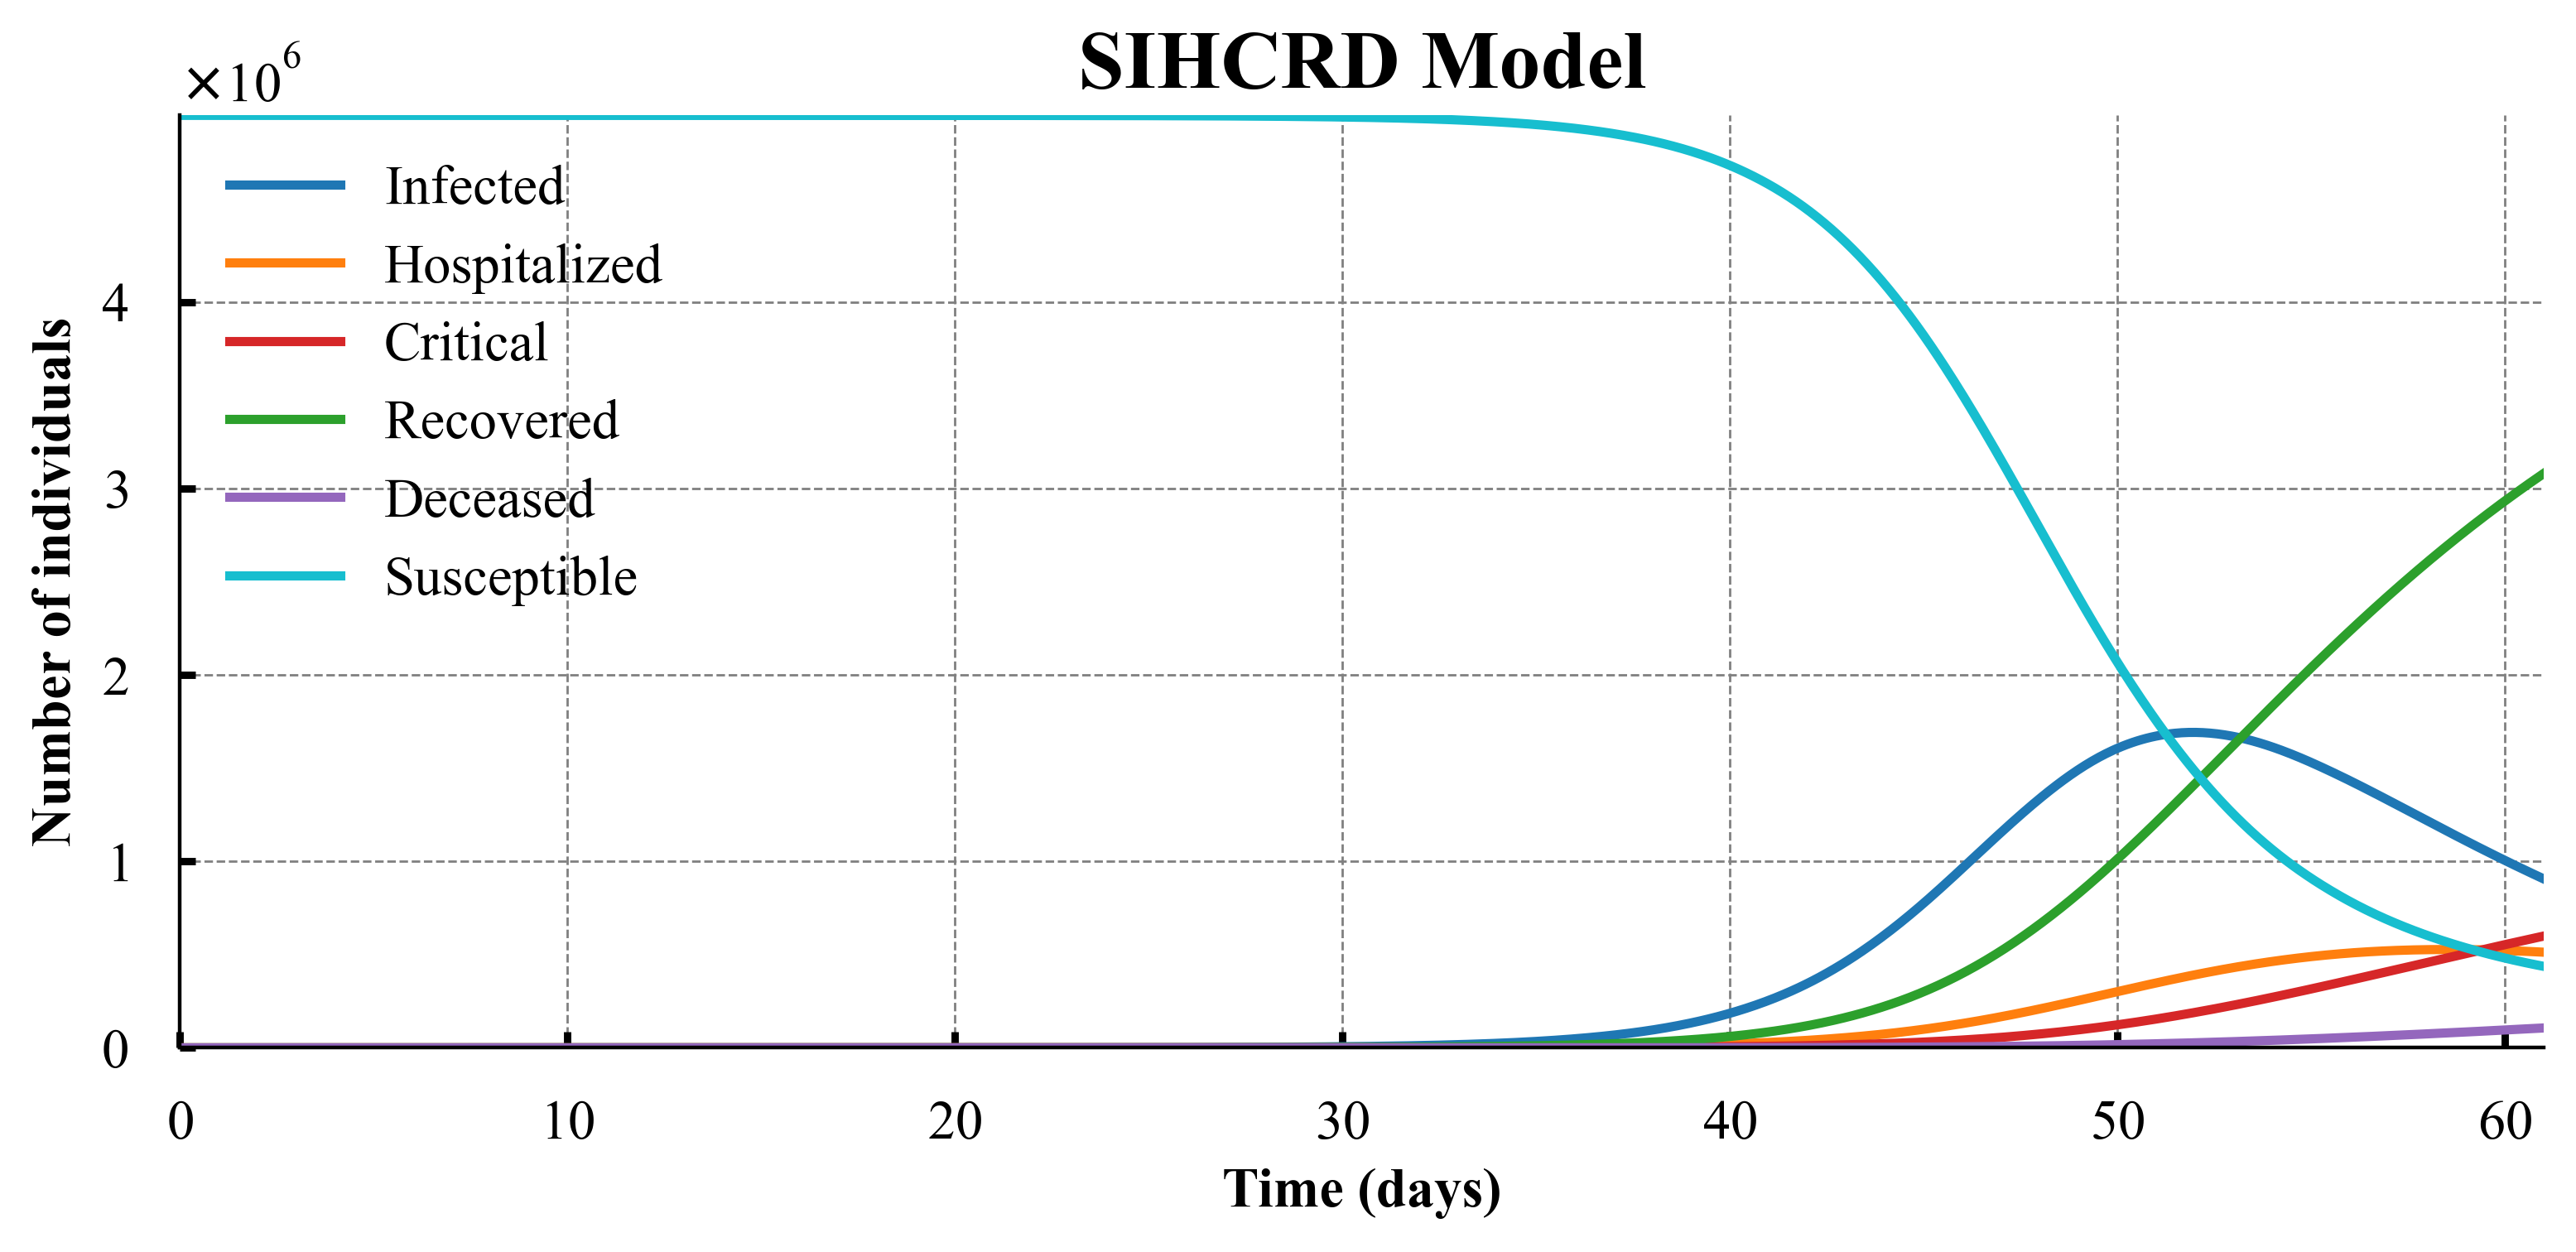

In [27]:
# using the trained model, predict and test on the validation data using the ODE model
model.eval()

# Define the initial conditions as the last point in the trained output
I0 = I_pred[-1].item()
H0 = H_pred[-1].item()
C0 = C_pred[-1].item()
R0 = R_pred[-1].item()
D0 = D_pred[-1].item()

# Define the initial conditions
y0 = initial_conditions(N, I0, H0, C0, R0, D0)

# extract the last value of beta
beta = beta_values[-1]

# Solve the system of differential equations to predict for the t_val
sol = solve_ivp(
    SIHCRD_model,
    [0, len(t_val)],
    y0,
    args=(beta, 0.1, 0.01, 0.05, N),
    dense_output=True,
)

# Extract the solution
t = np.linspace(0, len(t_val), 1000)
y = sol.sol(t)

# Plot the solution
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, y[1], label="Infected", color="tab:blue")
ax.plot(t, y[2], label="Hospitalized", color="tab:orange")
ax.plot(t, y[3], label="Critical", color="tab:red")
ax.plot(t, y[4], label="Recovered", color="tab:green")
ax.plot(t, y[5], label="Deceased", color="tab:purple")
ax.plot(t, y[0], label="Susceptible", color="tab:cyan")  # Add susceptible population
ax.set_xlabel("Time (days)")
ax.set_ylabel("Number of individuals")
ax.set_title("SIHCRD Model")
ax.legend()
plt.show()


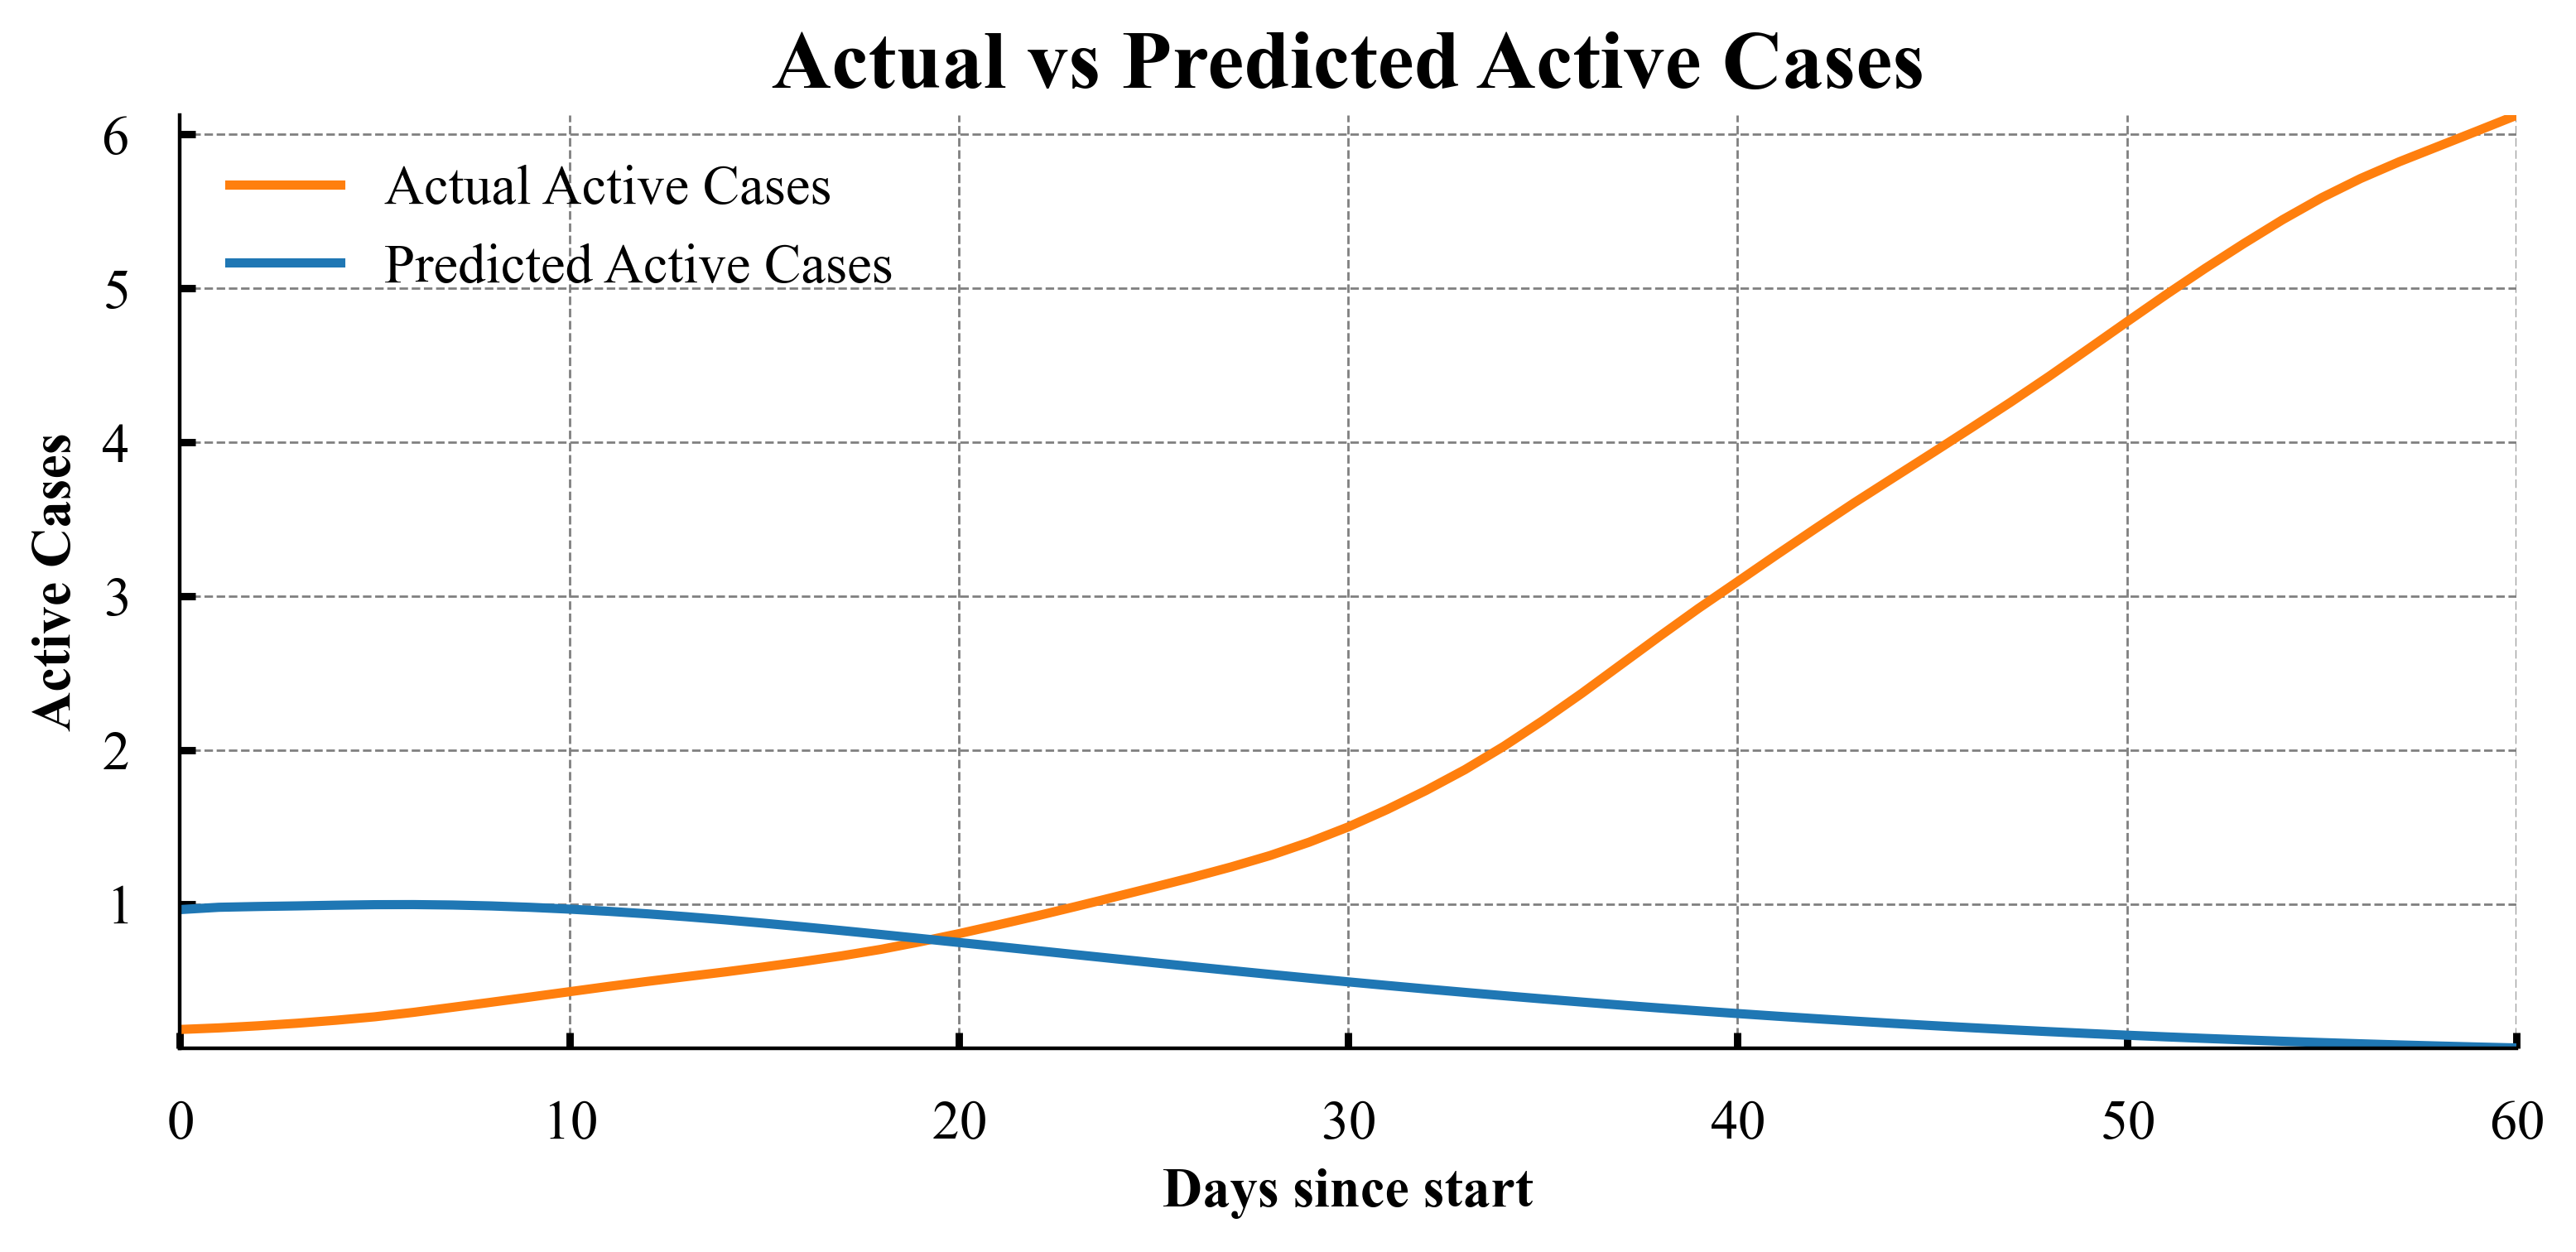

In [28]:
# predicting on the validation data
model.eval()
with torch.no_grad():
    t = t_val
    I_pred, H_pred, C_pred, R_pred, D_pred = model(t).unbind(1)
    
    # plot the actual and predicted of the validation data
    plt.plot(I_val.cpu().detach().numpy(), label="Actual Active Cases", color="tab:orange")
    plt.plot(I_pred.cpu().detach().numpy(), label="Predicted Active Cases", color="tab:blue")
    
    plt.title("Actual vs Predicted Active Cases")
    plt.xlabel("Days since start")
    plt.ylabel("Active Cases")
    plt.legend()
    plt.show()    

In [29]:
beta_value = beta_net(t).cpu().detach().numpy() 


S0 = N - I_train[0] - H_train[0] - C_train[0] - R_train[0] - D_train[0]  
y0 = [S0.item(), I_train[0].item(), H_train[0].item(), C_train[0].item(), R_train[0].item(), D_train[0].item()]

In [30]:
# Ensure t is handled correctly if it's a tensor
start_time = t_val[0].cpu().item()  # Get the start time as a float
end_time = t_val[-1].cpu().item()  # Get the end time as a float

# Simulate forward in time using solve_ivp
sol = solve_ivp(
    lambda t, y: SIHCRD_model(t, y, beta_value, gamma, delta, alpha, N),
    `
)

SyntaxError: invalid syntax (4136091711.py, line 8)

In [ ]:
# training loop using 30 time point of the training data and simulating forward in time
model.eval()
with torch.no_grad():
    t = t_train[:30]
    I_pred, H_pred, C_pred, R_pred, D_pred = model(t).unbind(1)
    
    # define the initial conditions
    S0 = N - I0 - H0 - C0 - R0 - D0
    y0 = [S0, I0, H0, C0, R0, D0]
    
    # simulate forward in time
    sol = solve_ivp(
        SIHCRD_model,
        [t[0].item(), t[-1].item()],
        y0,
        args=(beta_net(t), 0.1, 0.01, 0.05, N),
        dense_output=True,
    )
    
    # extract the solution
    t = np.linspace(t[0].item(), t[-1].item(), 1000)
    y = sol.sol(t)
    
    # plot the actual and predicted of the training data
    plt.plot(I_train.cpu().detach().numpy()[:30], label="Actual Active Cases")
    plt.plot(I_pred.cpu().detach().numpy(), label="Predicted Active Cases")
    plt.plot(t, y[1], label="Simulated Active Cases")
    plt.title("Actual vs Predicted Active Cases")
    plt.xlabel("Days since start")
    plt.ylabel("Active Cases")
    plt.legend()
    plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# # Filter train and validation datasets
# train_data = data[(data['date'] >= train_data_start) & (data['date'] <= train_data_end)]
# val_data = data[(data['date'] >= val_data_start) & (data['date'] <= val_data_end)]

# # Define features for scaling
# features = ["active_cases", "hospitalCases", "covidOccupiedMVBeds", "recovered", "new_deceased"]

# # Apply MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(train_data[features])
# scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
# scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

In [ ]:
# def prepare_tensors(data, device):
#     # Ensure the time tensor `t` requires gradients for autograd operations
#     t = torch.arange(1, len(data) + 1, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
#     tensors = [torch.tensor(data[feature].values, dtype=torch.float32).view(-1, 1).to(device) for feature in features]
#     return [t] + tensors


In [ ]:
# # Prepare tensors for training and validation data
# train_tensors = prepare_tensors(scaled_train_data, device)
# val_tensors = prepare_tensors(scaled_val_data, device)

# # Extract the tensors
# t_train, I_train, R_train, D_train, H_train, C_train = train_tensors
# t_val, I_val, R_val, D_val, H_val, C_val = val_tensors

# train_tensor = torch.cat([I_train, H_train, C_train, R_train, D_train], dim=1)
# val_tensor = torch.cat([I_val, H_val, C_val, R_val, D_val], dim=1)